# Telco Customer Churn

# Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE

import joblib

# Load Dataset

In [3]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/dqlab_telco.csv')

df.shape

(7113, 22)

In [4]:
# Showing top 5 rows of the data
df.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,0,Yes,No,1.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,202006,45557574145,Male,0,No,No,34.0,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,202006,45366876421,Male,0,No,No,2.0,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,202006,45779536532,Male,0,No,No,45.0,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,202006,45923787906,Female,0,No,No,2.0,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# sample 10 rows of the data
df.sample(10)

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
459,202006,45145215738,Male,0,No,No,1.0,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,75.10,75.10,No
2500,202006,45067904711,Male,0,Yes,Yes,50.0,Yes,No,DSL,...,No,Yes,Yes,Yes,One year,No,Electronic check,75.50,4025.60,No
4608,202006,45081301339,Male,0,No,No,55.0,Yes,Yes,DSL,...,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),77.80,4323.35,No
814,202006,45478541833,Male,1,No,No,5.0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.05,94.15,No
3729,202006,45363577874,Male,0,No,No,62.0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),20.05,1201.65,No
36,202006,45604748619,Male,0,No,No,5.0,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,69.70,316.90,Yes
4290,202006,45773442519,Female,0,Yes,Yes,1.0,No,No phone service,DSL,...,No,Yes,Yes,No,Month-to-month,No,Electronic check,40.10,40.10,Yes
2417,202006,45430712335,Male,0,No,No,10.0,No,No phone service,DSL,...,No,Yes,No,No,Month-to-month,No,Electronic check,35.75,389.80,No
5594,202006,45002712412,Female,0,Yes,Yes,23.0,Yes,Yes,Fiber optic,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,83.75,1849.95,No
3538,202006,45902829886,Male,0,Yes,Yes,71.0,Yes,No,Fiber optic,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),100.20,7209.00,No


In [6]:
df.customerID.nunique()

7017

# Data Cleansing

## Duplicated Data Check

### Filter Customer ID Number with Specific Format

To find the correct format for the customer's phone number `customerID` with the following criteria:

*   The length of characters is 11-12.
*   It consists of digits only; no characters other than digits are allowed.
*   It starts with the digits 45 (the first 2 digits).

In [7]:
df['valid_id'] = df['customerID'].astype(str).str.match(r'(45\d{9,10})')
df = (df[df['valid_id'] == True]).drop('valid_id', axis = 1)
print('The number of filtered customer IDs is', df['customerID'].count())

The number of filtered customer IDs is 7006


### Filter Duplicate Customer ID

Ensure that there are no duplicate customer ID numbers. Typically, the types of duplication are:

* Duplication due to inserting more than once with the same value in each column.
* Duplication due to inserting data from different periods of data collection.

In [8]:
# Drop Duplicate Rows
df.drop_duplicates()

# Drop duplicate ID sorted by Periode
df = df.sort_values('UpdatedAt', ascending=False).drop_duplicates(['customerID'])
print('The number of customer IDs after removing duplicates (distinct) is', df['customerID'].count())

The number of customer IDs after removing duplicates (distinct) is 6993


The validity of customer ID numbers is crucial to ensure that the data we collect is accurate. Based on the results, there is a difference in the number of ID numbers from the initial data load to the final result. **The initial data** load contained **7113 rows and 22 columns**, with **7017 unique IDs**. After **validating** the customer IDs, the data was reduced to **6993 rows**.

## Missing Value

### Handling Missing Values by Removing Rows

In [9]:
print('The total number of missing values in the Churn column', df['Churn'].isnull().sum())
# Dropping all Rows with spesific column (churn)
df.dropna(subset=['Churn'],inplace=True)
print('The total number of rows and columns in the data after removing missing values.', df.shape)

The total number of missing values in the Churn column 43
The total number of rows and columns in the data after removing missing values. (6950, 22)


### Handling Missing Values by Filling with Specific Values

Assuming the data modeler requests the following criteria for filling in missing values:

* For the "Tenure" variable, each row with missing values should be filled with the value 11.
* For numeric variables other than "Tenure," missing values should be filled with the median of each respective variable.

In [10]:
print('Status Missing Values :',df.isnull().values.any())
print('\nThe number of missing values in each column is:')
print(df.isnull().sum().sort_values(ascending=False))

# handling missing values Tenure fill with 11
df['tenure'].fillna(11, inplace=True)

# Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
	median = df[col_name].median()
	df[col_name].fillna(median, inplace=True)

print('\nThe number of missing values after imputing the data is:')
print(df.isnull().sum().sort_values(ascending=False))

Status Missing Values : True

The number of missing values in each column is:
tenure              99
MonthlyCharges      26
TotalCharges        15
UpdatedAt            0
DeviceProtection     0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
OnlineBackup         0
customerID           0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
Dependents           0
Partner              0
SeniorCitizen        0
gender               0
Churn                0
dtype: int64

The number of missing values after imputing the data is:
UpdatedAt           0
customerID          0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService   

## Outliers Handling

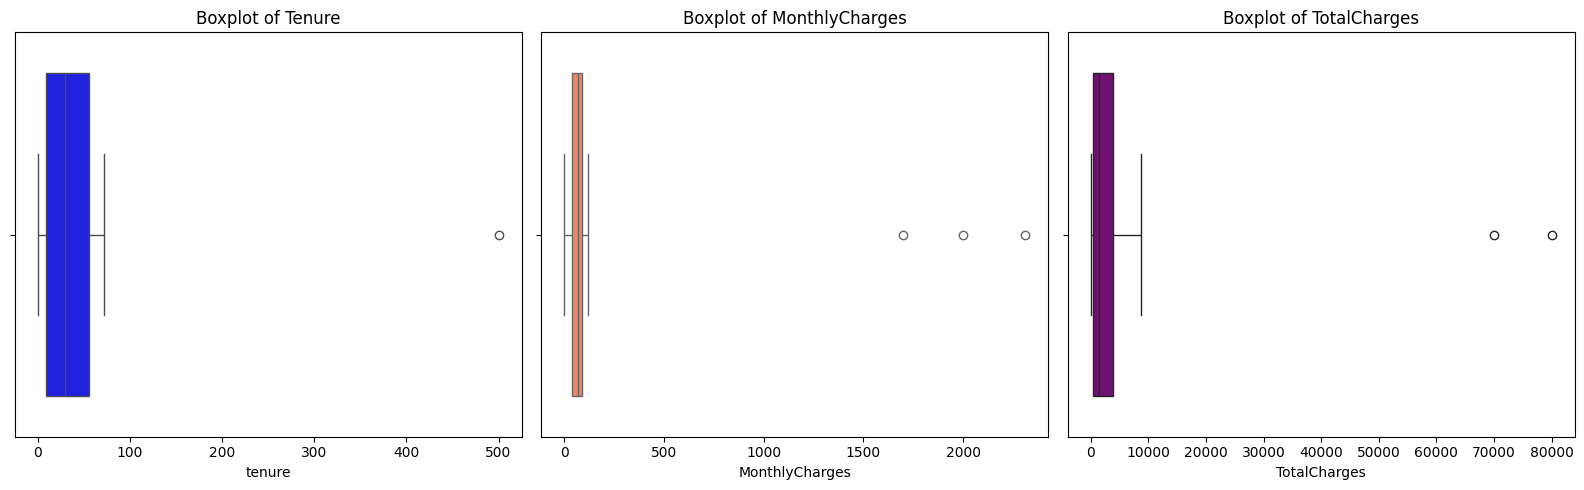

In [11]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot the boxplot for 'tenure'
sns.boxplot(x=df['tenure'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot of Tenure')

# Plot the boxplot for 'MonthlyCharges'
sns.boxplot(x=df['MonthlyCharges'], color='coral', ax=axes[1])
axes[1].set_title('Boxplot of MonthlyCharges')

# Plot the boxplot for 'TotalCharges'
sns.boxplot(x=df['TotalCharges'], color='purple', ax=axes[2])
axes[2].set_title('Boxplot of TotalCharges')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
# Handling with IQR
Q1 = (df[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Delete outlier
df_load = df[~((df[['tenure','MonthlyCharges','TotalCharges']] < lower_bound) | (df[['tenure','MonthlyCharges','TotalCharges']] > upper_bound)).any(axis=1)]
df_load.reset_index(drop=True, inplace=True)

In [13]:
df_load.shape

(6945, 22)

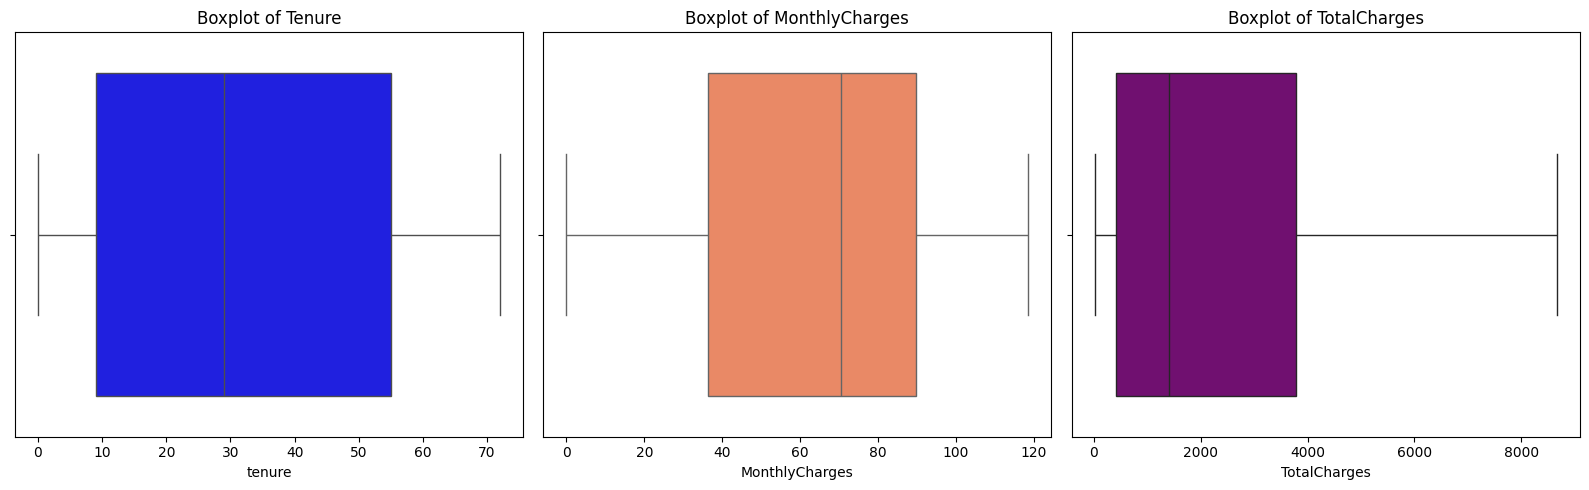

In [14]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot the boxplot for 'tenure'
sns.boxplot(x=df_load['tenure'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot of Tenure')

# Plot the boxplot for 'MonthlyCharges'
sns.boxplot(x=df_load['MonthlyCharges'], color='coral', ax=axes[1])
axes[1].set_title('Boxplot of MonthlyCharges')

# Plot the boxplot for 'TotalCharges'
sns.boxplot(x=df_load['TotalCharges'], color='purple', ax=axes[2])
axes[2].set_title('Boxplot of TotalCharges')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Data Understanding

In [15]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UpdatedAt         6945 non-null   int64  
 1   customerID        6945 non-null   object 
 2   gender            6945 non-null   object 
 3   SeniorCitizen     6945 non-null   int64  
 4   Partner           6945 non-null   object 
 5   Dependents        6945 non-null   object 
 6   tenure            6945 non-null   float64
 7   PhoneService      6945 non-null   object 
 8   MultipleLines     6945 non-null   object 
 9   InternetService   6945 non-null   object 
 10  OnlineSecurity    6945 non-null   object 
 11  OnlineBackup      6945 non-null   object 
 12  DeviceProtection  6945 non-null   object 
 13  TechSupport       6945 non-null   object 
 14  StreamingTV       6945 non-null   object 
 15  StreamingMovies   6945 non-null   object 
 16  Contract          6945 non-null   object 


The `UpdatedAt` variabel has an incorrect data type (int), and it needs to be converted to a object data type

In [16]:
#Transform UpdatedAt to object
df_load['UpdatedAt'] = df_load['UpdatedAt'].astype('object')

All data types (dtypes) seem **appropriate**, given the corresponding column name.

## Statistical Summary

In [17]:
categorical = []
numeric = []
for col in df_load.columns:
    if df_load[col].dtypes == 'object':
        categorical.append(col)
    else:
        numeric.append(col)

In [18]:
# numerical statistical summary
df_load[numeric].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,6945.000000,6945.000000,6945.000000,6945.000000
mean,0.162419,32.387905,64.934658,2281.750641
std,0.368861,24.548067,29.954345,2260.747418
min,0.000000,0.000000,0.000000,19.000000
25%,0.000000,9.000000,36.450000,406.050000
50%,0.000000,29.000000,70.450000,1400.850000
75%,0.000000,55.000000,89.850000,3789.200000
max,1.000000,72.000000,118.600000,8670.100000


In [19]:
# categorical summary
for category in categorical:
    print(df_load[category].value_counts())
    print()

UpdatedAt
202006    6945
Name: count, dtype: int64

customerID
45759018157    1
45384146533    1
45371440465    1
45594860526    1
45776054644    1
              ..
45630490697    1
45958607718    1
45450113661    1
45607592492    1
45957014561    1
Name: count, Length: 6945, dtype: int64

gender
Male         3498
Female       3427
Wanita         14
Laki-Laki       6
Name: count, dtype: int64

Partner
No     3590
Yes    3355
Name: count, dtype: int64

Dependents
No     4866
Yes    2059
Iya      20
Name: count, dtype: int64

PhoneService
Yes    6276
No      669
Name: count, dtype: int64

MultipleLines
No                  3346
Yes                 2930
No phone service     669
Name: count, dtype: int64

InternetService
Fiber optic    3052
DSL            2388
No             1505
Name: count, dtype: int64

OnlineSecurity
No                     3454
Yes                    1986
No internet service    1505
Name: count, dtype: int64

OnlineBackup
No                     3045
Yes                 

## Standardizing Non-Standard Values

In [20]:
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])

In [21]:
for category in categorical:
	print('\nUnique Values Count \033[1m' + 'After Standardized \033[0mVariable',category)
	print(df_load[category].value_counts())


Unique Values Count After Standardized Variable UpdatedAt
UpdatedAt
202006    6945
Name: count, dtype: int64

Unique Values Count After Standardized Variable customerID
customerID
45759018157    1
45384146533    1
45371440465    1
45594860526    1
45776054644    1
              ..
45630490697    1
45958607718    1
45450113661    1
45607592492    1
45957014561    1
Name: count, Length: 6945, dtype: int64

Unique Values Count After Standardized Variable gender
gender
Male      3504
Female    3441
Name: count, dtype: int64

Unique Values Count After Standardized Variable Partner
Partner
No     3590
Yes    3355
Name: count, dtype: int64

Unique Values Count After Standardized Variable Dependents
Dependents
No     4866
Yes    2079
Name: count, dtype: int64

Unique Values Count After Standardized Variable PhoneService
PhoneService
Yes    6276
No      669
Name: count, dtype: int64

Unique Values Count After Standardized Variable MultipleLines
MultipleLines
No                  3346
Yes       

# Exploratory Data Analysis

## Univariate Analysis

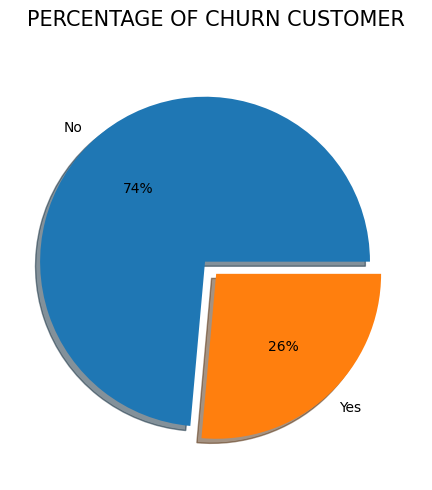

In [22]:
# Percentage of Churn Customer
per_churn = df_load.groupby('Churn')['customerID'].count().reset_index()
plt.pie(per_churn['customerID'],
        labels= per_churn['Churn'],
        shadow=True,
        explode=[0.1, 0],
        autopct='%0.f%%')
plt.title('PERCENTAGE OF CHURN CUSTOMER', loc='center', pad=30, fontsize=15)
plt.gcf().set_size_inches(12, 5)
plt.tight_layout()
plt.show()

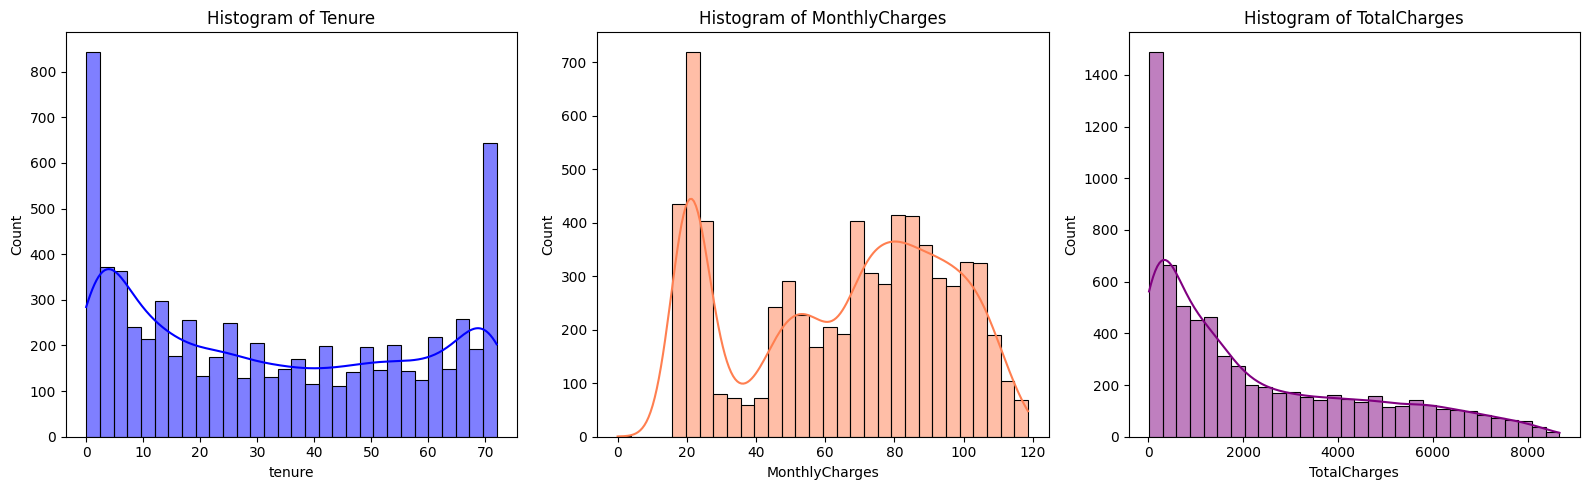

In [23]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot the histogram with distribution line for 'tenure'
sns.histplot(df_load['tenure'], bins=30, color='blue', kde=True, ax=axes[0])
axes[0].set_title('Histogram of Tenure')

# Plot the histogram with distribution line for 'MonthlyCharges'
sns.histplot(df_load['MonthlyCharges'], bins=30, color='coral', kde=True, ax=axes[1])
axes[1].set_title('Histogram of MonthlyCharges')

# Plot the histogram with distribution line for 'TotalCharges'
sns.histplot(df_load['TotalCharges'], bins=30, color='purple', kde=True, ax=axes[2])
axes[2].set_title('Histogram of TotalCharges')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


*   `Tenure` suggests that a considerable number of customers have shorter tenure durations, as indicated by the peak around the lower values. The distribution is right-skewed, with a tail extending towards higher tenure values.
*   `MonthlyCharges` exhibits a peak around the lower values, indicating that a large number of customers have lower monthly charges. The distribution is right-skewed, with fewer customers paying higher monthly charges.
*   `TotalCharges` is positively skewed, with a high concentration towards lower total charges. This indicates that many customers have incurred lower total charges over their tenure, with fewer customers accumulating higher total charges.






In [24]:
# group column names based on type
# it will make our life easier onwards
category_columns = ['gender', 'Partner', 'Dependents','PhoneService', 'PaperlessBilling', 'MultipleLines','OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

ordinal_columns = ['InternetService', 'Contract', 'PaymentMethod']

In [25]:
def categorical_plots(df_load, category, type):

    num_cols = 3
    length = len(category)
    num_rows = length // 3 + 1 if length % 3 != 0 else length // 3

    size_x = num_cols * length if type == 'categorical' else num_cols * 7
    size_y = num_cols * num_rows if type == 'categorical' else num_cols * 2


    fig, axs = plt.subplots(num_rows, num_cols, figsize=(size_x,size_y))

    colors = ['red', 'coral', 'purple', 'orange', 'green', 'skyblue']

    for index, axes in enumerate(axs.flatten()[:len(category)]):
        df_load[category[index]].value_counts(normalize=True).plot(kind='bar',
                                                              ax = axes,
                                                              title = category[index].capitalize(),
                                                              color = colors[index]).set_xlabel("")
        axes.set_ylim(0,1)

        if type == 'categorical':
            axes.tick_params(axis='x', rotation=0)
        else:
            axes.tick_params(axis='x', rotation=45)

        position = df_load[category[index]].value_counts(normalize=True)
        get_position = position.tolist()
        data_point = position.apply(lambda x : x*100).astype('str').apply(lambda x : x[:5] +" %").tolist()

        for i in range(len(get_position)):
            axes.text(i, get_position[i], data_point[i],
                      ha='center', color = 'black', fontsize=10)

    plt.subplots_adjust(wspace=0.2,
                        hspace=0.3)

In [26]:
category_1 = category_columns[:len(category_columns)//2]
category_2 = category_columns[6:]

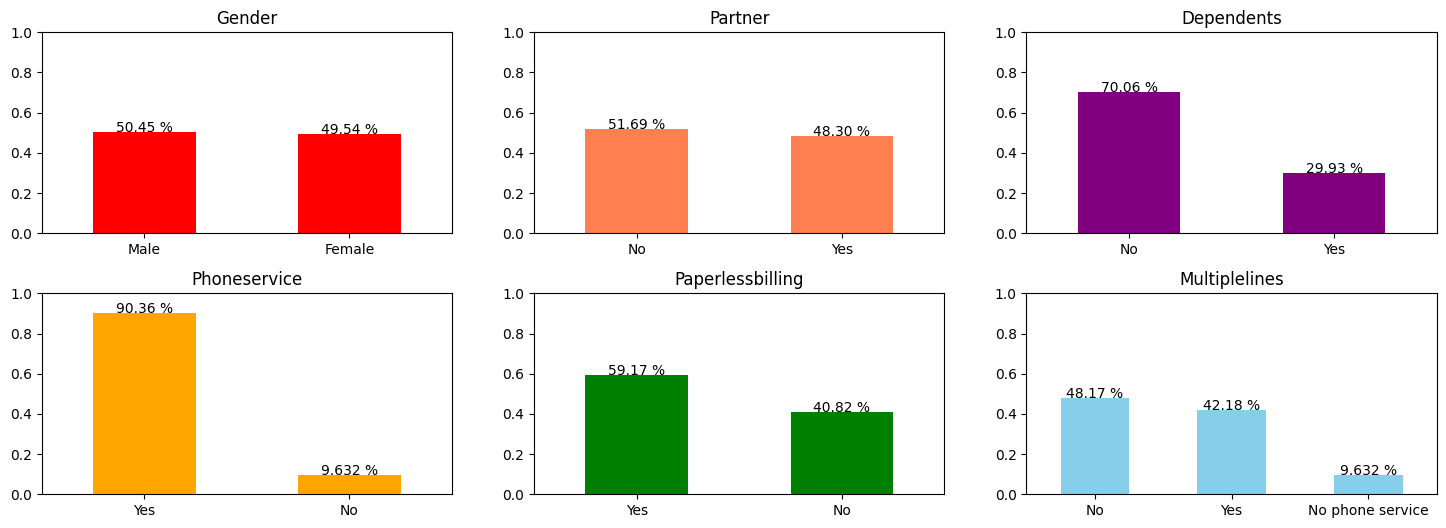

In [27]:
categorical_plots(df_load, category_1, 'categorical')

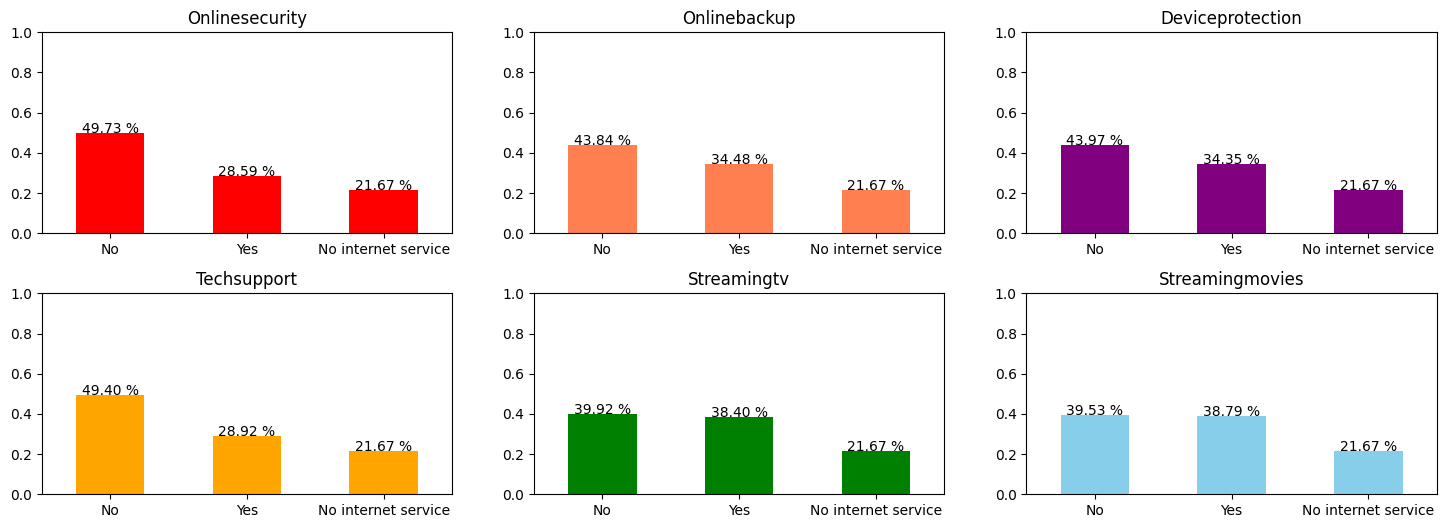

In [28]:
categorical_plots(df_load, category_2, 'categorical')

* The distribution of users, both in terms of gender and partner status, is impressively balanced. We have an equitable representation of male and female users, as well as individuals with and without partners.
* There is a noticeable difference between customers with and without dependents, with 29.93% having dependents. Similar patterns can be observed in the use of telephone services.
* The percentage of customers opting for paperless billing is somewhat comparable to those who do not, although most customers show a strong preference for paperless billing.
* Almost the same persentage of customers use or don't use features like `MultipleLines`, `OnlineSecurity`, `OnlineBackup`,` DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies`. But most folks is not use them.

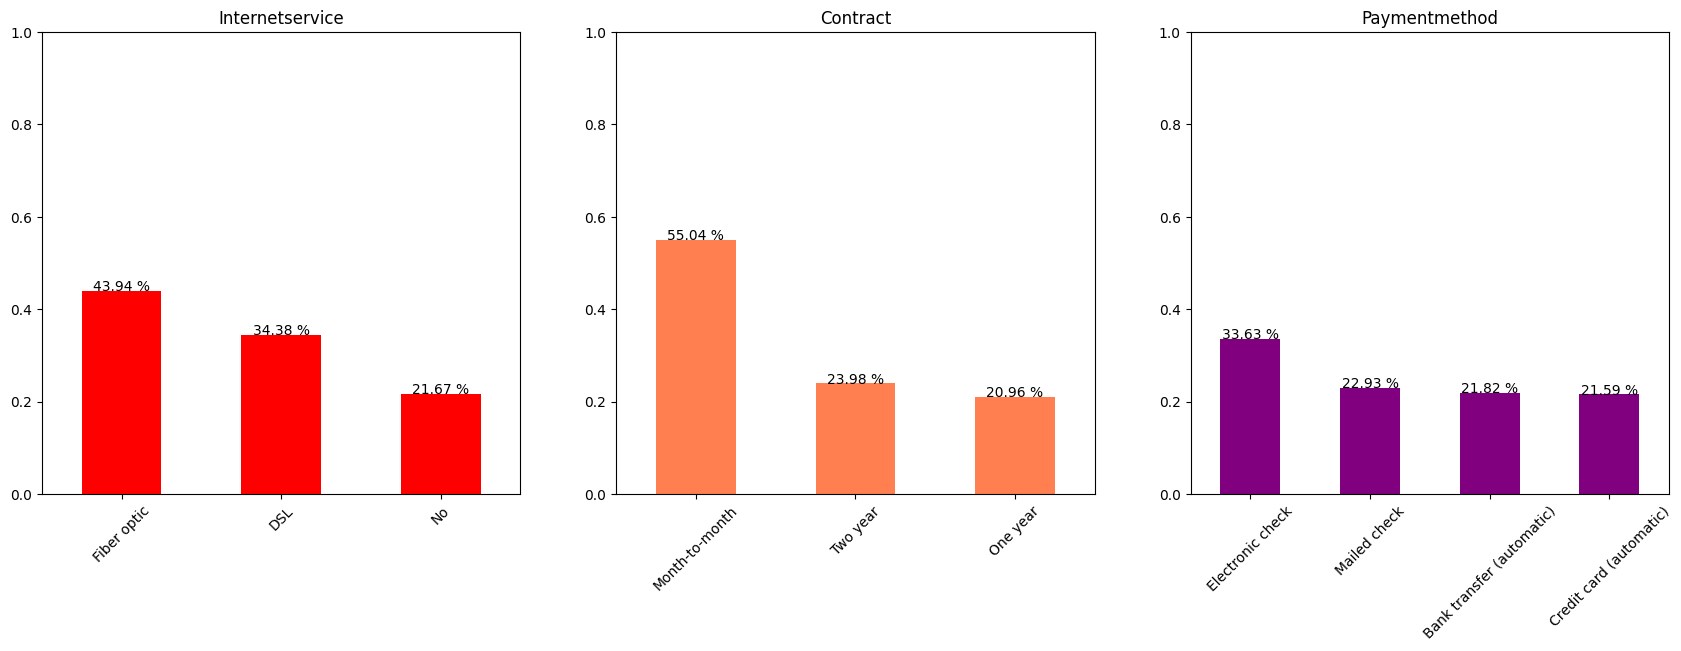

In [29]:
categorical_plots(df_load, ordinal_columns, 'ordinal')

* The service usage graph indicates that most customers prefer fiber optic service over DSL or no internet service.

* The contract graph clearly shows that more than 50% of customers prefer monthly payments rather than annual contracts.

* Electronic checks are the most popular payment method among customers, while other payment methods have relatively equal percentages.

## Bivariate Analysis

In [30]:
# Remember the dataset
df_load.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,0,Yes,No,1.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,202006,45315483266,Male,0,Yes,No,60.0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.50,1198.80,No
2,202006,45236961615,Male,0,No,No,5.0,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,No,Mailed check,104.10,541.90,Yes
3,202006,45929827382,Female,0,Yes,No,72.0,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),115.50,8312.75,No
4,202006,45305082233,Female,0,Yes,Yes,56.0,Yes,Yes,DSL,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),81.25,4620.40,No


**Does the type of contract influence churn?**

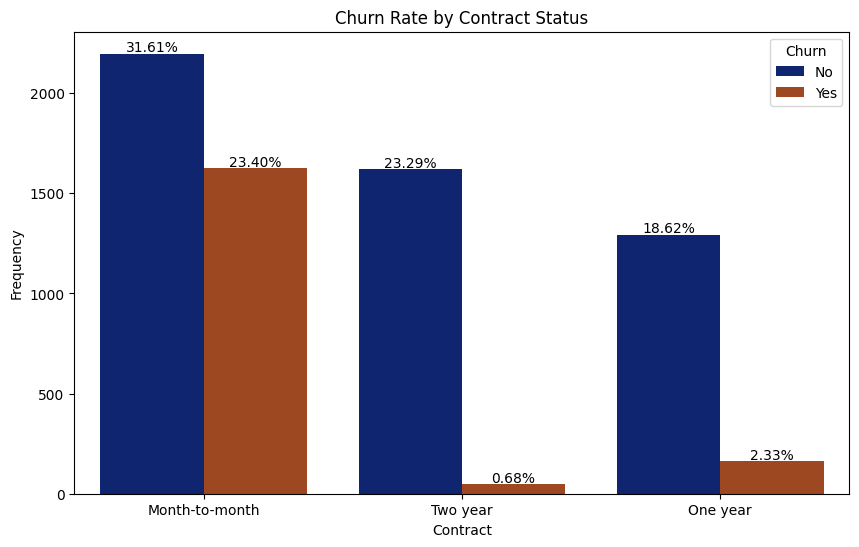

In [31]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Contract', hue='Churn', data=df_load, palette="dark")

# Add percentage labels on top of the bars
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    if height != 0:  # Add this condition to check if the height is not zero
        ax.text(p.get_x() + p.get_width() / 2, height + 10, f'{(height/total) * 100:.2f}%', ha="center")

# Set plot title and labels
plt.title("Churn Rate by Contract Status")
plt.xlabel("Contract")
plt.ylabel("Frequency")

# Show the plot
plt.show()

The churn rate for customers with monthly (month to month) contracts is significantly higher compared to those with long-term contracts (one year and two year). Customers with long-term contracts show a lower tendency to discontinue the service (churn).

**Does the type of Internet Service influence Churn?**

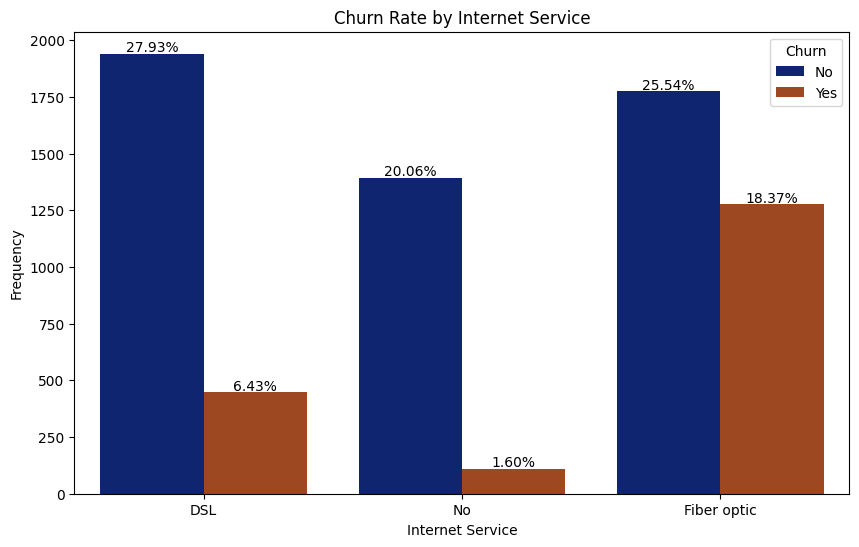

In [32]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='InternetService', hue='Churn', data=df_load, palette="dark")

# Add percentage labels on top of the bars
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    if height != 0:  # Add this condition to check if the height is not zero
        ax.text(p.get_x() + p.get_width() / 2, height + 10, f'{(height/total) * 100:.2f}%', ha="center")

# Set plot title and labels
plt.title("Churn Rate by Internet Service")
plt.xlabel("Internet Service")
plt.ylabel("Frequency")

# Show the plot
plt.show()

The highest churn rate is observed among customers using fiber optic services, followed by those using DSL (internet service that uses a phone line connection). This indicates that customers with internet service are more likely to churn compared to those without internet service.

**Does the type of Dependents influence Churn?**

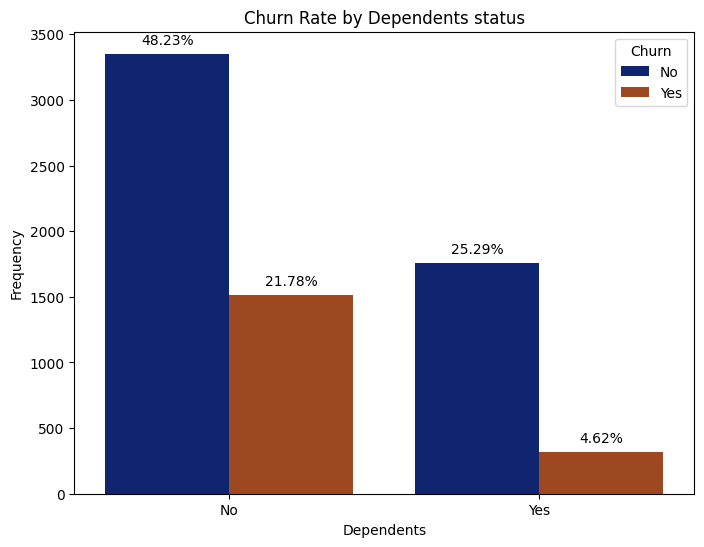

In [33]:
# Create the count plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Dependents', hue='Churn', data=df_load, palette="dark")

# Add percentage labels on top of the bars
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    if height != 0:  # Add this condition to check if the height is not zero
        ax.text(p.get_x() + p.get_width() / 2, height + total*0.01, f'{(height/total) * 100:.2f}%', ha="center")

# Set plot title and labels
plt.title("Churn Rate by Dependents status")
plt.xlabel("Dependents")
plt.ylabel("Frequency")

# Show the plot
plt.show()


From this graph, we observe that churn is more prevalent among customers without dependents compared to those with dependents. This suggests that customers with dependents are less likely to churn than those without dependents.

**Does the length of Tenure influence Churn?**

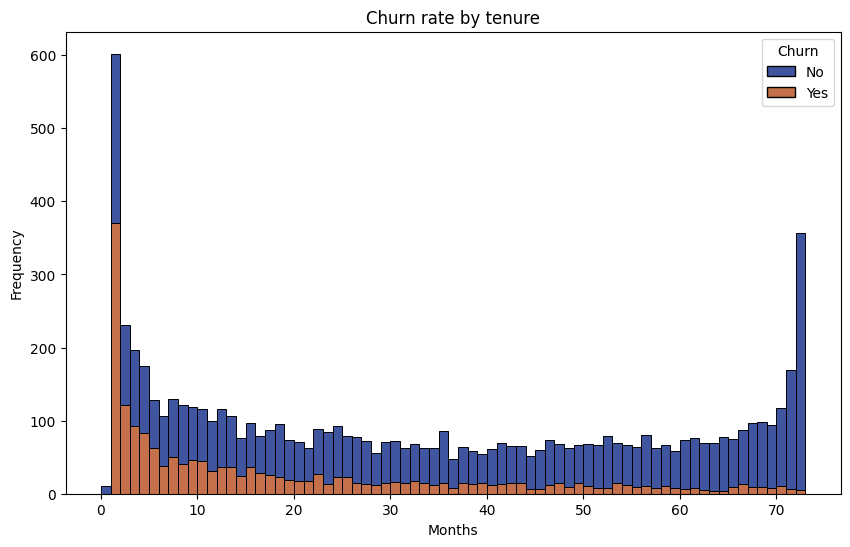

In [34]:
# Create the histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_load, x='tenure', bins=range(0, int(max(df_load['tenure'])) + 2, 1), hue='Churn', multiple="stack", palette="dark")

# Set plot title and labels
plt.title("Churn rate by tenure")
plt.xlabel("Months")
plt.ylabel("Frequency")

# Show the plot
plt.show()

The graph indicates that customers who churn are more likely to be those who have used the service for **less than 5 months**. The highest frequency of customer churn occurs in the first month of service usage. This suggests that many customers decide to stop using the service within the initial five months, with the majority discontinuing in the very first month. Possible reasons for this trend could include unsatisfactory initial experiences, quick assessments of the service, potential offers from competitors, or early customer dissatisfaction.

<Axes: >

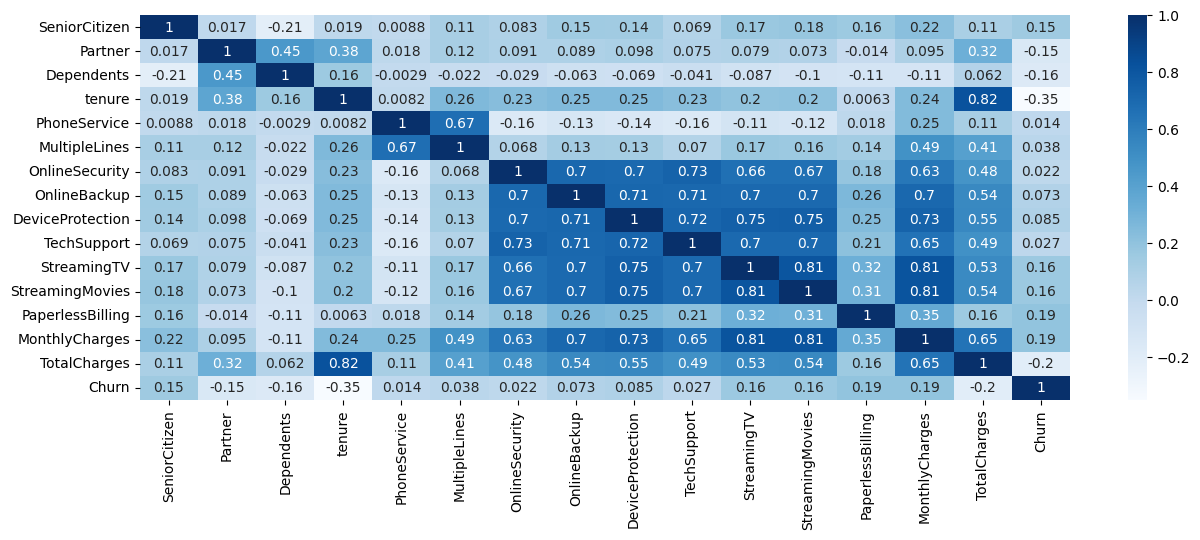

In [35]:
# Delete Unecessary Columns
cleaned_df = df_load.drop(['customerID', 'UpdatedAt'], axis=1)
cleaned_df.reset_index(drop=True, inplace=True)

# change the categorical value to numeric value
# No phone service / No internet service = 0, No = 1, Yes = 2
df_changes = cleaned_df.copy()

# Exclude 'UpdatedAt' and 'customerID' columns
columns_to_exclude = ['UpdatedAt', 'customerID']
categorical = [col for col in df_changes.columns if col not in columns_to_exclude and df_changes[col].dtype == 'object']

# Loop through each categorical column
for col in df_changes[categorical]:
    df_changes[col].replace({"No phone service" : 0}, inplace=True)
    df_changes[col].replace({"No internet service" : 0}, inplace=True)
    df_changes[col].replace({"No" :  1}, inplace=True)
    df_changes[col].replace({"Yes" : 2}, inplace=True)

plt.figure(figsize=(15,5))
sns.heatmap(df_changes.corr(numeric_only = True),cbar=True,annot=True,cmap='Blues')

*   `tenure` and `TotalCharges` show a strong positive correlation of 0.82. This indicates that customers with longer subscription periods tend to have higher total charges. This means that if customers continue using the service for a long time, they will accumulate larger total charges over time.
*   `SteamingTV`, `StreamingMovie`, and `MonthlyCharges` are also strongly correlated. `StreamingTV` and `StreamingMovie` are closely related as both involve video content streaming. Users subscribing to `StreamingTV` services might also be interested in `StreamingMovie` services, and vice versa. Additionally, MonthlyCharger is strongly correlated with `StreamingTV/StreamingMovie`, as these streaming services typically require a monthly subscription fee.
*   Even though we found strong connections in other areas, it turns out that the chance of customers leaving (churn) doesn't seem closely tied to other things. This is evident from the low correlation values with other variables.





## Deep Dive EDA

**EDA Questions**
1. What types of internet services are most commonly used by customers?
2. Which contract types are predominantly chosen by customers?
3. How does customers churn relate to having dependents, types of internet service, and contract choices?

### 1. Commonly Used Types of Internet Services by Customers

In [36]:
# Type of Internet Service wit the most commonly used by customers
top_internet_service = (df_load
            .groupby('InternetService')
            .agg(num_trx=('customerID','count'))
            .reset_index()
            .sort_values('num_trx',ascending=False)
            )
top_internet_service

,InternetService,num_trx
1,Fiber optic,3052
0,DSL,2388
2,No,1505


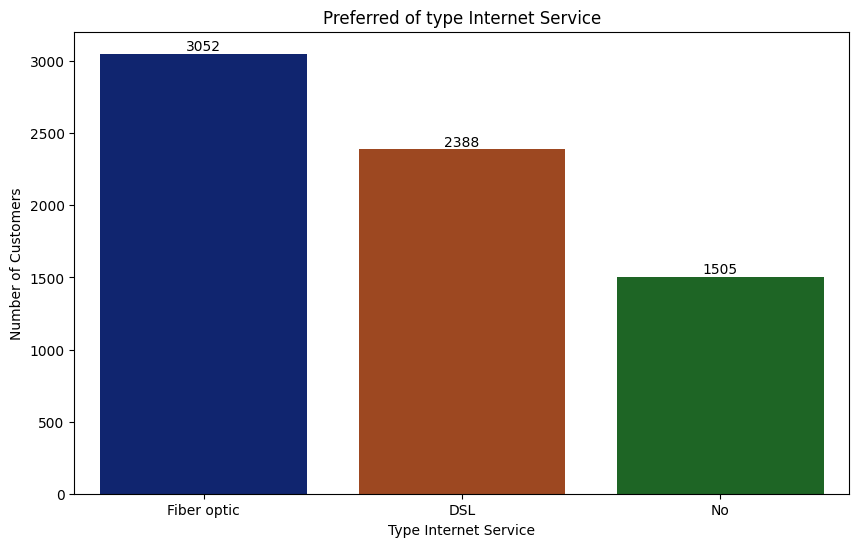

In [37]:
# Plotting the bar chart with a reduced figure size
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=top_internet_service, x='InternetService', y='num_trx', hue='InternetService', palette='dark')

# Adding labels to each bar
for index, value in enumerate(top_internet_service['num_trx']):
    bar_plot.text(
        index,
        value + 0.1,  # Adjust this value for vertical positioning of the label
        str(value),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Preferred of type Internet Service')
plt.xlabel('Type Internet Service')
plt.ylabel('Number of Customers')
plt.show()

The most commonly used types of internet services by customers are Fiber Optic with total customers are 3052. This indicates that many customers prefer high-speed internet and are interested in advanced technology, emphasizing the importance of a stable and reliable connection in their choice of internet service.

### 2. Contract types are predominantly chosen by customers

In [38]:
#  the preferred payment methods among customers
top_contract = (df_load
            .groupby('Contract')
            .agg(num_trx=('customerID','count'))
            .reset_index()
            .sort_values('num_trx',ascending=False)
            )
top_contract

,Contract,num_trx
0,Month-to-month,3823
2,Two year,1666
1,One year,1456


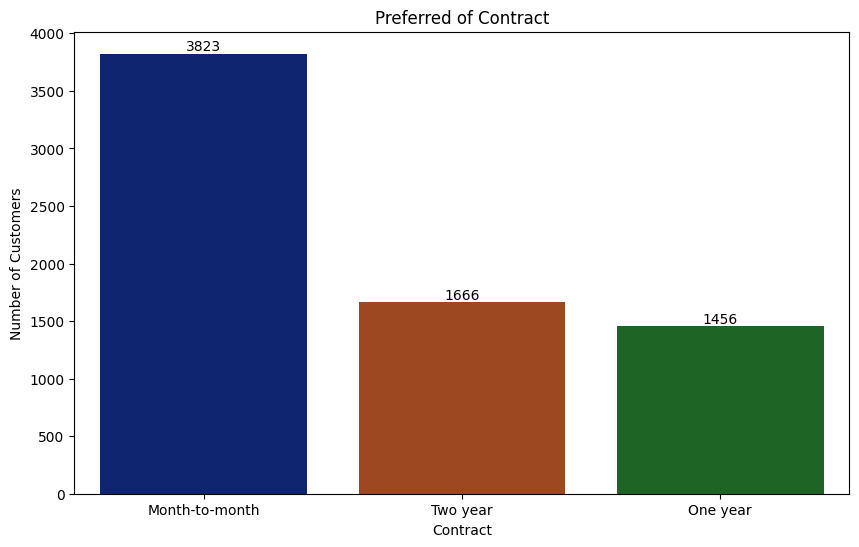

In [39]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=top_contract, x='Contract', y='num_trx', hue='Contract', palette='dark')

# Adding labels to each bar
for index, value in enumerate(top_contract['num_trx']):
    bar_plot.text(
        index,
        value + 0.1,  # Adjust this value for vertical positioning of the label
        str(value),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Preferred of Contract')
plt.xlabel('Contract')
plt.ylabel('Number of Customers')
plt.show()

Customers predominantly choose the "Month-to-month" contract type, with a total of 3823 customers. This means that half of the customers prefer making month-to-month payments without a long-term commitment. This preference suggests that customers value financial flexibility, the ability to adapt to changing needs, and the freedom to stop using the service without significant consequences.

### 3. How does customers churn relate to Dependents, Internet Service, and Contract

In [40]:
def bivariate_bar_plot(df_load, ordinal_columns, target_variabel, type):

    if type == 'barstacked':
        fig, axs = plt.subplots(1,3, figsize = (18,5))
        colors = [['coral','lightseagreen'], ['purple','lightseagreen'], ['lightseagreen', 'orange'] ]

        for index, axes in enumerate(axs.flatten()):
            df_stack = df_load.groupby([target_variabel, ordinal_columns[index]]).size().reset_index()
            df_stack = df_stack.pivot(columns= target_variabel, index= ordinal_columns[index], values=0)
            df_reverse = df_stack[df_stack.columns[::-1]]

            df_reverse.plot(kind='bar', stacked=True, ax = axes,
                            title = ordinal_columns[index], color = colors[index],
                            ylabel = 'Frequency').set_xlabel("")

            axes.tick_params(axis='x', rotation=0)

            for c in axes.containers:
                label = [int(l.get_height()) for l in c]
                axes.bar_label(c, labels = label, label_type = 'edge')

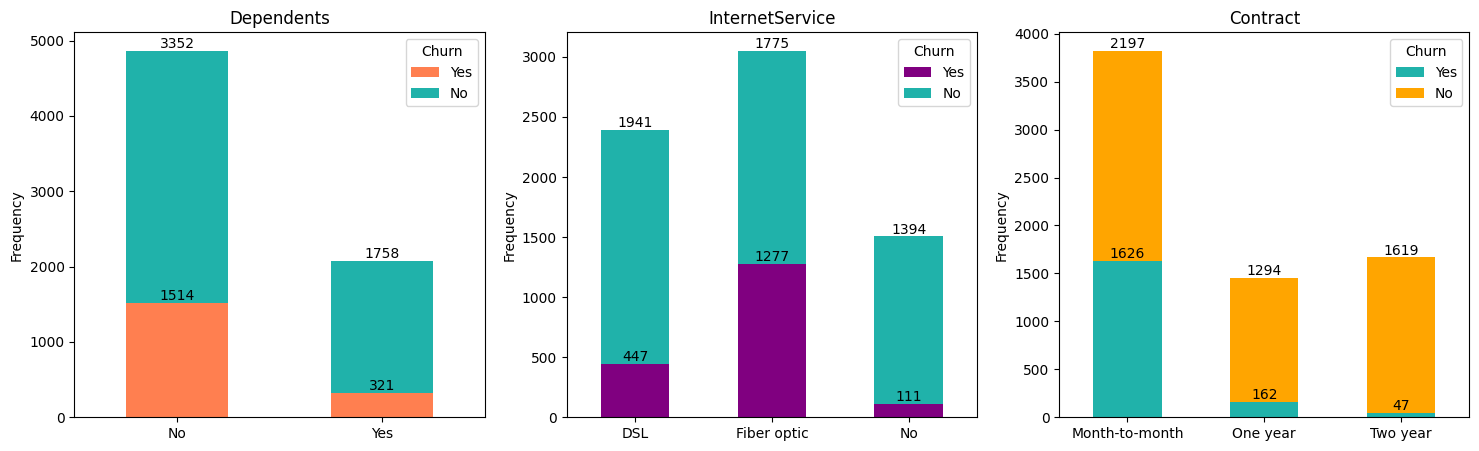

In [41]:
columns = ['Dependents', 'InternetService', 'Contract']
bivariate_bar_plot(df_load, columns, 'Churn', 'barstacked')

Graph 1 - Dependants

*   The relationship between customer churn and having dependents suggests that customers without dependents are more likely to churn compared to those with dependents. On the graph, the tomato color indicates that 1514 customers without dependents stopped using the service, which is significantly higher than those with dependents. This suggests that customers without dependents use the service for themselves. Therefore, their decision to churn is often influenced by personal factors such as financial stability, personal changes, and flexibility in spending, without the consideration of family needs.




Graph 2 - Internet Service
* More customers experience churn among those using fiber optic internet service compared to those using DSL. The purple-colored graph shows that a total of 1277 fiber optic users are affected by churn, which is higher than in both other user categories. Possible reasons could include service quality issues, cost and package differences, and less satisfactory user experiences. Conversely, the graph indicates that the lowest churn occurs among customers without internet service, with only 111 individuals. This means that customers with internet service are more likely to churn compared to those without internet service. Financial constraints might lead some customers to opt for essential services like telephone-only subscriptions.

Graph 3 - Contract
* Customers who churn are more prevalent among those who choose monthly contracts compared to annual contracts (one year and two years). The blue-colored graph illustrates customers churning based on different contract choices, indicating that a total of 1626 individuals churned in the monthly payment category. This highlights that monthly contracts provide flexibility for customers to unsubscribe each month without significant consequences. Uncertain financial considerations drive some customers to opt for this choice to adjust service costs to their monthly financial conditions.

# Data Preprocessing

## Label Encoding and One Hot Encoding

In [42]:
#see the unique values of each column
for col in cleaned_df.columns:
    if cleaned_df[col].dtypes == object:
        print('{} : {}'.format(col, df_load[col].unique()))

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'No' 'Fiber optic']
OnlineSecurity : ['No' 'No internet service' 'Yes']
OnlineBackup : ['Yes' 'No internet service' 'No']
DeviceProtection : ['No' 'No internet service' 'Yes']
TechSupport : ['No' 'No internet service' 'Yes']
StreamingTV : ['No' 'No internet service' 'Yes']
StreamingMovies : ['No' 'No internet service' 'Yes']
Contract : ['Month-to-month' 'Two year' 'One year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Bank transfer (automatic)' 'Mailed check'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [43]:
# Encode the categorical variable into numeric
def label_encoding(cleaned_df, ordinal_columns):

    categoricals = cleaned_df.drop(columns = ordinal_columns, axis=1).columns

    for col in categoricals:
        cleaned_df[col] = cleaned_df[col].replace({'Male' : 1, 'Female' : 0,
                                   								'Yes' : 1, 'No' : 0,
                                   								'No phone service' : 0,
                                   								'No internet service' : 0})
    return cleaned_df

In [44]:
label_encoding(cleaned_df, ordinal_columns).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1.0,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,1,0,60.0,1,0,No,0,0,0,0,0,0,Two year,1,Bank transfer (automatic),20.50,1198.80,0
2,1,0,0,0,5.0,1,1,Fiber optic,0,1,1,0,1,1,Month-to-month,0,Mailed check,104.10,541.90,1
3,0,0,1,0,72.0,1,1,Fiber optic,1,1,1,1,1,1,Two year,1,Bank transfer (automatic),115.50,8312.75,0
4,0,0,1,1,56.0,1,1,DSL,1,1,1,1,1,0,Two year,0,Credit card (automatic),81.25,4620.40,0


In [45]:
# Encode ordinal columns, and drop last encoding-columns to avoid multicollinearity
def onehotencoding(cleaned_df, columns):

    onehot = pd.DataFrame()
    for col in columns:
        encoding = pd.get_dummies(cleaned_df[col], prefix=col, dtype='float')
        encoding = encoding.drop(encoding.columns[-1], axis=1)
        onehot = pd.concat([onehot, encoding], axis=1)

    return onehot

In [46]:
onehotencoding(cleaned_df, ordinal_columns).head()

,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0


All columns have been converted to numeric, and we also removed the last column in Internet Service, Contract, and PaymentMethod because failing to do so would result in a very high Variance Inflation Factor (VIF).

## Multicolinearity Handling

In [47]:
# Calculate multicollinearity
def calculate_vif(feature):
    X = add_constant(feature)
    vif_df = pd.DataFrame([VIF(X.values, i) for i in range(X.shape[1])],
                          index = X.columns).reset_index()
    vif_df.columns = ['feature', 'vif_score']
    vif_df = vif_df.loc[vif_df.feature != 'const']
    return vif_df

In [48]:
def feature_cleaning(cleaned_df, ordinal_columns):
    # Ensure 'Churn' is numeric
    cleaned_df['Churn'] = cleaned_df['Churn'].astype(int)

    # Label encode ordinal columns
    df_encode = label_encoding(cleaned_df, ordinal_columns)

    # Drop ordinal columns and target column from features
    df_encode = df_encode.drop(columns=ordinal_columns)
    feature = df_encode.drop(columns='Churn')
    target = df_encode['Churn']

    # Drop MonthlyCharges and TotalCharges since their VIF scores are high
    feature = feature.drop(columns=['MonthlyCharges', 'TotalCharges'], axis=1)

    # One-hot encode ordinal columns
    onehot = onehotencoding(cleaned_df, ordinal_columns)
    feature = pd.concat([feature, onehot], axis=1)

    return feature, target

feature, target = feature_cleaning(cleaned_df, ordinal_columns)

# Check the VIF score
calculate_vif(feature)

,feature,vif_score
1,gender,1.001897
2,SeniorCitizen,1.154460
3,Partner,1.462696
4,Dependents,1.386654
5,tenure,2.768263
6,PhoneService,1.352224
7,MultipleLines,1.419582
8,OnlineSecurity,1.413394
9,OnlineBackup,1.380218
10,DeviceProtection,1.479846


<Axes: >

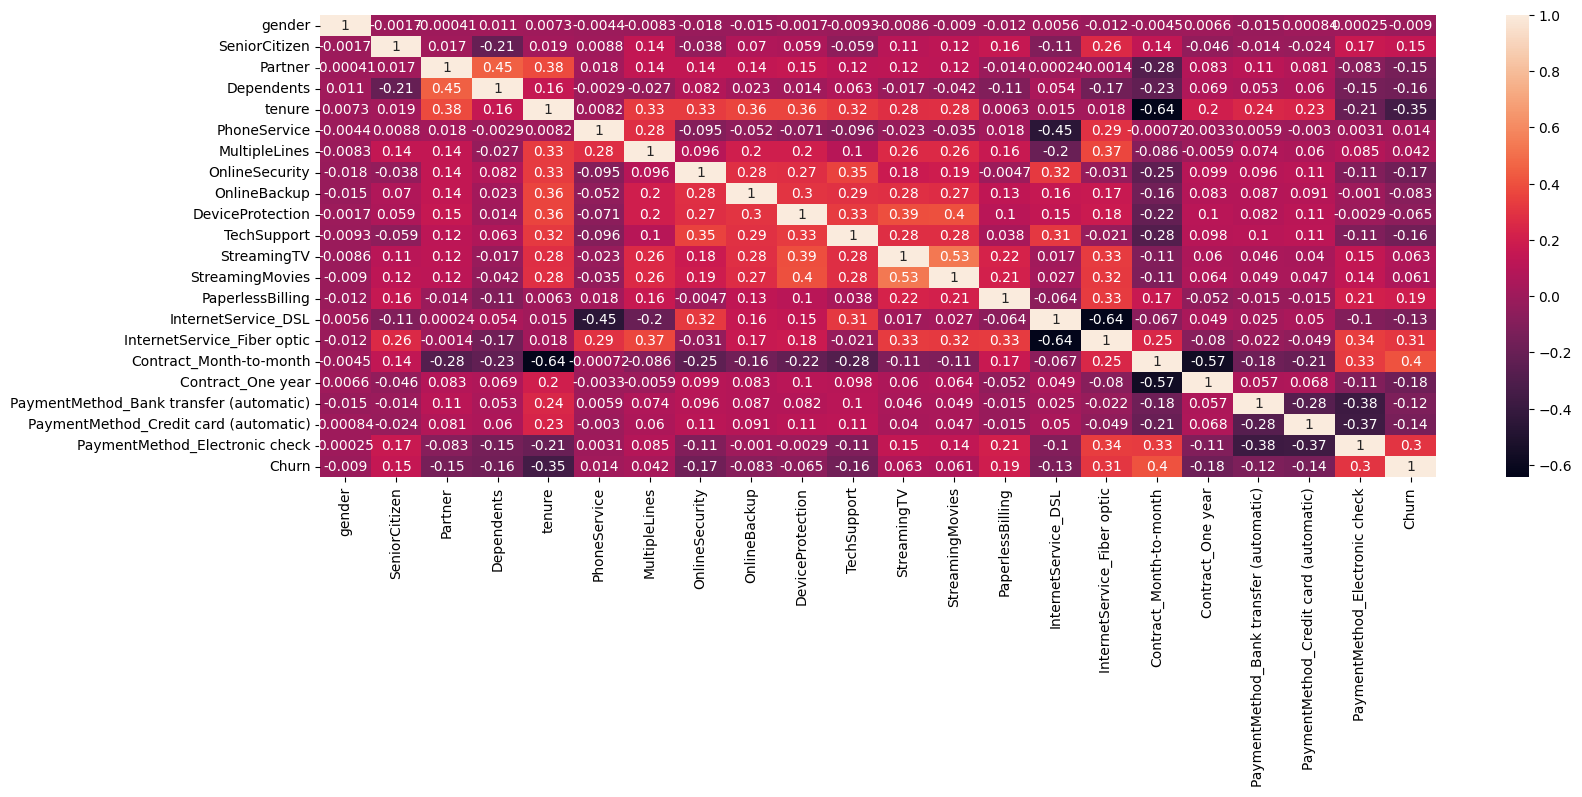

In [49]:
correlation = pd.concat([feature, target], axis=1)

plt.figure(figsize=(18,6))
sns.heatmap(correlation.corr(), annot=True)

It appears that there are no variables with strong correlations, indicating good VIF values and effectively addressed multicollinearity issues. Good!


## Splitting Dataset

In [50]:
# Splitting train and test
X_pretrain, X_val, y_pretrain, y_val = train_test_split(feature,
                                                        target,
                                                        test_size=0.2,
                                                        random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_pretrain,
                                                    y_pretrain,
                                                    test_size=0.2,
                                                    random_state=42)

In [51]:
# Original feature and target shape of our dataset
print('Shape of original feature data : {}'.format(feature.shape))
print('Shape of original target data : {}'.format(target.shape))
print()

# Shape of X_train and y_train data
print('Shape of X_train data : {}'.format(X_train.shape))
print('Shape of y_train data : {}'.format(y_train.shape))
print()

# Shape of X_test and y_test data
print('Shape of X_test data : {}'.format(X_test.shape))
print('Shape of y_test data : {}'.format(y_test.shape))
print()

# Shape of X_val and y_val data
print('Shape of X_val data : {}'.format(X_val.shape))
print('Shape of y_val data : {}'.format(y_val.shape))
print()

Shape of original feature data : (6945, 21)
Shape of original target data : (6945,)

Shape of X_train data : (4444, 21)
Shape of y_train data : (4444,)

Shape of X_test data : (1112, 21)
Shape of y_test data : (1112,)

Shape of X_val data : (1389, 21)
Shape of y_val data : (1389,)



Now we will try the model without SMOTE and with SMOTE to compare their results.

# Model Building

## Without SMOTE (Synthetic Minority Over-sampling Technique)

In [52]:
def Models_Evaluation_Metrics (model,X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred):
    acc_train=round(model.score(X_train,y_train)*100,2)
    acc_test=round(model.score(X_test,y_test)*100,2)
    acc_val=round(model.score(X_val,y_val)*100,2)

    return acc_train, acc_test, acc_val

    print("Training Accuracy: {}%".format(acc_train))
    print("Test Accuracy: {}%".format(acc_test))
    print("Validation Accuracy: {}%".format(acc_val))

### Logistic Regression

In [53]:
log_model = LogisticRegression().fit(X_train, y_train)
y_train_pred = log_model.predict(X_train)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred, target_names=labels))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

    No churn       0.85      0.90      0.87      3268
       Churn       0.67      0.56      0.61      1176

    accuracy                           0.81      4444
   macro avg       0.76      0.73      0.74      4444
weighted avg       0.80      0.81      0.80      4444



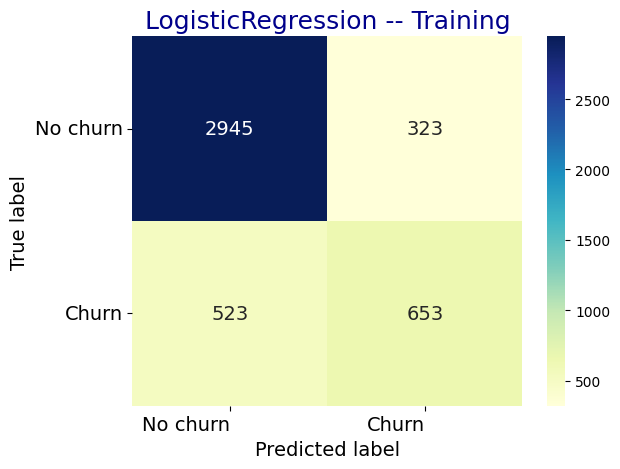

In [54]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('LogisticRegression -- Training', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [55]:
# Predict data test
y_test_pred = log_model.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

    No churn       0.84      0.90      0.87       820
       Churn       0.65      0.52      0.58       292

    accuracy                           0.80      1112
   macro avg       0.74      0.71      0.72      1112
weighted avg       0.79      0.80      0.79      1112



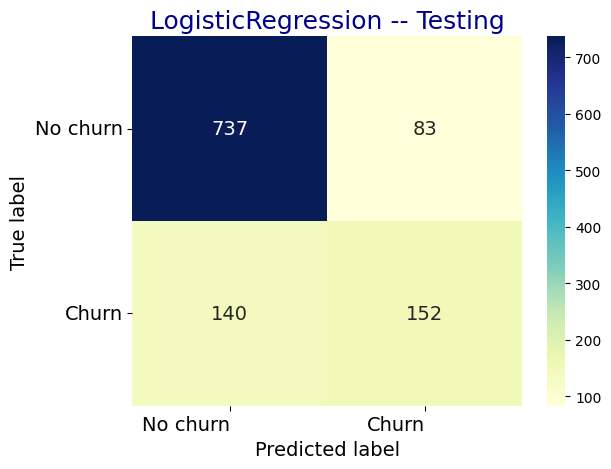

In [56]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)),('No churn','Churn'),('No churn','Churn') )
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14},fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('LogisticRegression -- Testing', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [57]:
# Predict data val
y_val_pred = log_model.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (Logistic Regression):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (Logistic Regression):
              precision    recall  f1-score   support

    No churn       0.84      0.90      0.87      1022
       Churn       0.65      0.51      0.57       367

    accuracy                           0.80      1389
   macro avg       0.74      0.70      0.72      1389
weighted avg       0.79      0.80      0.79      1389



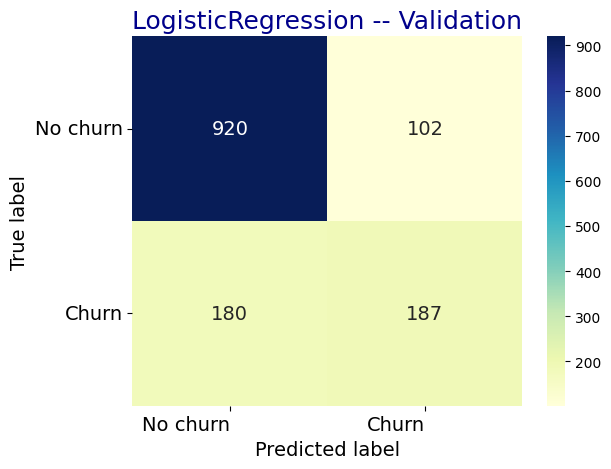

In [58]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)),('No churn','Churn'),('No churn','Churn') )
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14},fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('LogisticRegression -- Validation', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [59]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(log_model, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]

log_model_score = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy', 'Validation Accuracy'])
log_model_score.insert(0, 'Model', 'Logistic Regression')

### Decision Tree Classifier

In [60]:
tree_model = DecisionTreeClassifier().fit(X_train, y_train)
y_train_pred = tree_model.predict(X_train)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Training Model (Decision Tree) :')
print(classification_report(y_train, y_train_pred, target_names=labels))

Classification Report Training Model (Decision Tree) :
              precision    recall  f1-score   support

    No churn       0.98      0.99      0.99      3268
       Churn       0.98      0.95      0.97      1176

    accuracy                           0.98      4444
   macro avg       0.98      0.97      0.98      4444
weighted avg       0.98      0.98      0.98      4444



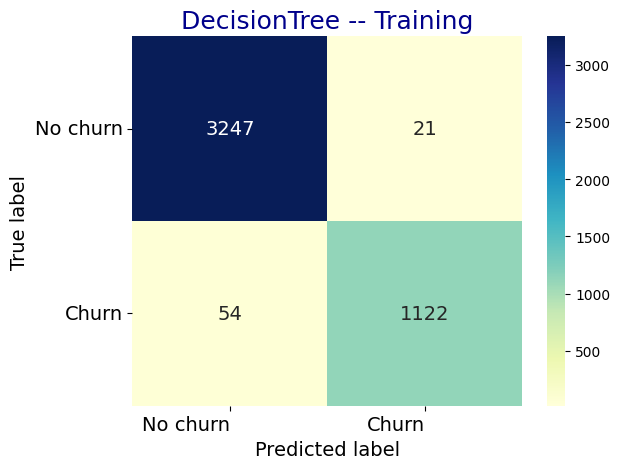

In [61]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('DecisionTree -- Training', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
y_test_pred = tree_model.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (Decision Tree):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (Decision Tree):
              precision    recall  f1-score   support

    No churn       0.81      0.81      0.81       820
       Churn       0.46      0.46      0.46       292

    accuracy                           0.72      1112
   macro avg       0.63      0.63      0.63      1112
weighted avg       0.72      0.72      0.72      1112



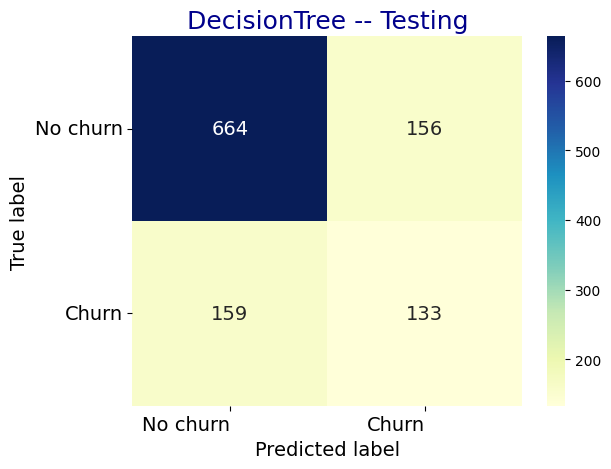

In [63]:
# Performa data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('DecisionTree -- Testing', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [64]:
y_val_pred = tree_model.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (Decision Tree):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (Decision Tree):
              precision    recall  f1-score   support

    No churn       0.80      0.83      0.82      1022
       Churn       0.48      0.43      0.45       367

    accuracy                           0.72      1389
   macro avg       0.64      0.63      0.64      1389
weighted avg       0.72      0.72      0.72      1389



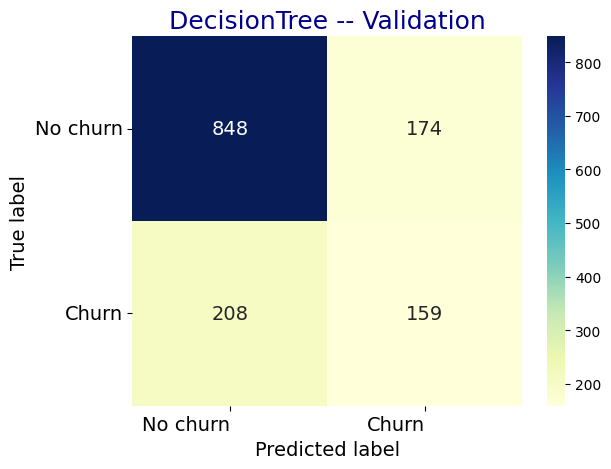

In [65]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('DecisionTree -- Validation', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [66]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(tree_model, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]
tree_model_score = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy', 'Validation Accuracy'])
tree_model_score.insert(0, 'Model', 'Decision Tree')

### Random Forest Classifier

In [67]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Training Model (Random Forest Classifier) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest Classifier) :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3268
           1       0.97      0.96      0.97      1176

    accuracy                           0.98      4444
   macro avg       0.98      0.98      0.98      4444
weighted avg       0.98      0.98      0.98      4444



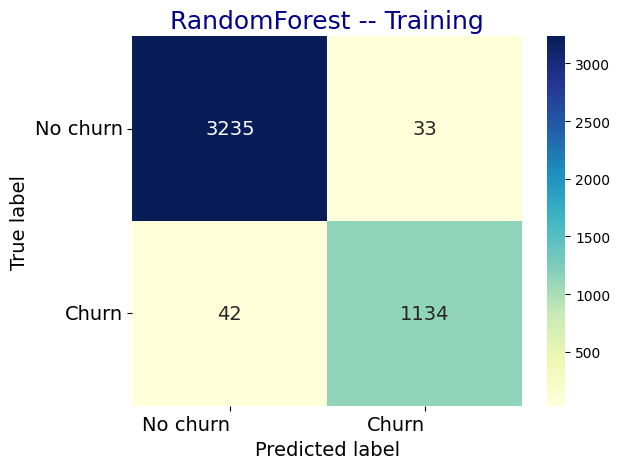

In [68]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('RandomForest -- Training', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [69]:
# Predict data test
y_test_pred = rf_model.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

    No churn       0.82      0.90      0.86       820
       Churn       0.61      0.46      0.52       292

    accuracy                           0.78      1112
   macro avg       0.72      0.68      0.69      1112
weighted avg       0.77      0.78      0.77      1112



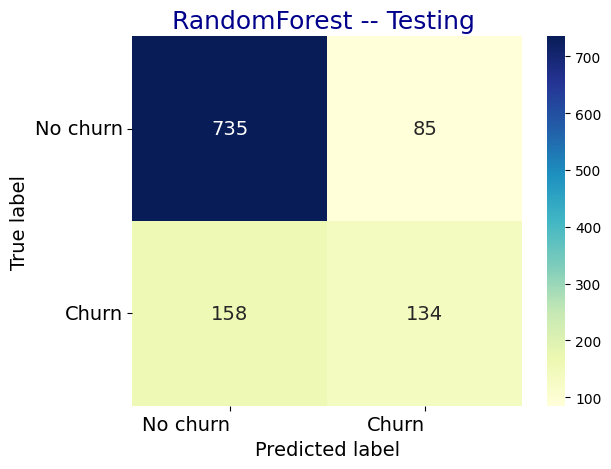

In [70]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('RandomForest -- Testing ', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [71]:
y_val_pred = rf_model.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (Random Forest Classifier):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (Random Forest Classifier):
              precision    recall  f1-score   support

    No churn       0.82      0.91      0.86      1022
       Churn       0.64      0.46      0.54       367

    accuracy                           0.79      1389
   macro avg       0.73      0.68      0.70      1389
weighted avg       0.78      0.79      0.78      1389



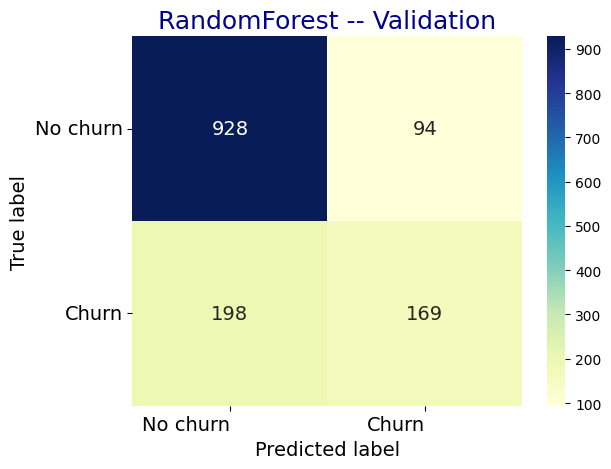

In [72]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('RandomForest -- Validation', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [73]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(rf_model, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]

rf_model_score = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy','Validation Accuracy'])
rf_model_score.insert(0, 'Model', 'Random Forest')

### Extreme Gradient Boosting (XGBoost)

In [74]:
xgb_model = XGBClassifier().fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
labels = ['No churn', 'Churn']
# Print classification report
print('Classification Report Training Model (XGBoost):')
print(classification_report(y_train,y_train_pred, target_names=labels))

Classification Report Training Model (XGBoost):
              precision    recall  f1-score   support

    No churn       0.95      0.96      0.96      3268
       Churn       0.89      0.87      0.88      1176

    accuracy                           0.94      4444
   macro avg       0.92      0.92      0.92      4444
weighted avg       0.94      0.94      0.94      4444



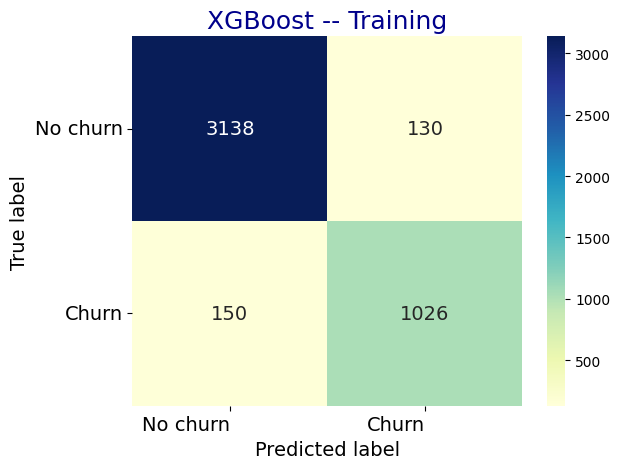

In [75]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('XGBoost -- Training', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [76]:
# Predict data test
y_test_pred = xgb_model.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (XGBoost):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (XGBoost):
              precision    recall  f1-score   support

    No churn       0.83      0.89      0.86       820
       Churn       0.61      0.50      0.55       292

    accuracy                           0.79      1112
   macro avg       0.72      0.70      0.71      1112
weighted avg       0.78      0.79      0.78      1112



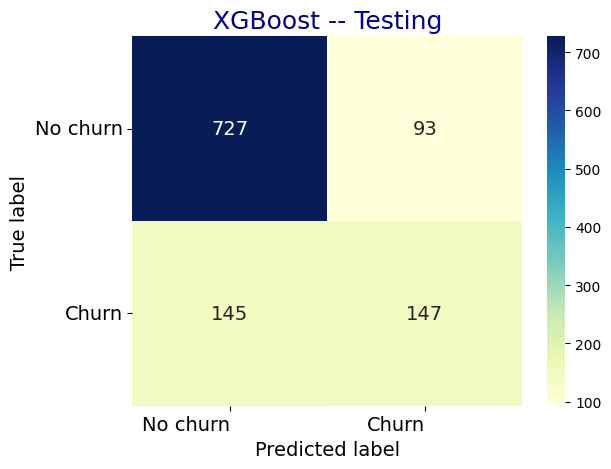

In [77]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('XGBoost -- Testing', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [78]:
# Predict data val
y_val_pred = xgb_model.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (XGBoost):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (XGBoost):
              precision    recall  f1-score   support

    No churn       0.83      0.89      0.86      1022
       Churn       0.61      0.49      0.54       367

    accuracy                           0.78      1389
   macro avg       0.72      0.69      0.70      1389
weighted avg       0.77      0.78      0.77      1389



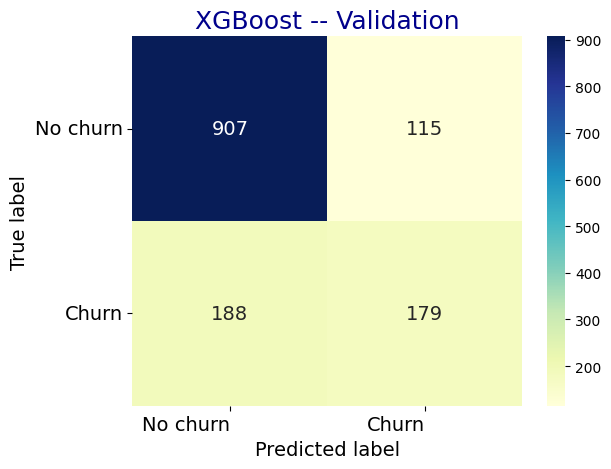

In [79]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('XGBoost -- Validation', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [80]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(xgb_model, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]

xgb_model_score = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy','Validation Accuracy'])
xgb_model_score.insert(0, 'Model', 'XGBoost')

## With SMOTE (Synthetic Minority Over-sampling Technique)

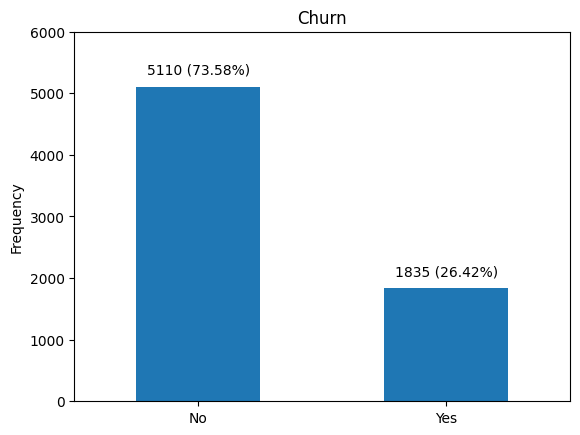

In [81]:
def imbalanced_viz(target):
    # Mapping class labels into 'No' and 'Yes'
    target_class = target.map({0 : 'No', 1 : 'Yes'})

    # Plot the number of each class in the form of a bar chart
    target_class.value_counts().plot(kind='bar', title='Churn')
    plt.tick_params(axis='x', rotation=0)
    plt.xlabel('')
    plt.ylabel('Frequency')

    counts = target_class.value_counts()
    percentage = counts / np.sum(counts) * 100

    labels = [str(counts[0]) + " (" + f'{percentage[0]:.2f}' + '%' + ")",
              str(counts[1]) + " (" + f'{percentage[1]:.2f}' + '%' + ")"]

    for i in range(len(labels)):
        plt.text(i, counts[i] + 200, labels[i],
                 ha='center', color = 'black', fontsize=10)

    plt.ylim(0,6000)
    plt.show()

imbalanced_viz(target)

There is an imbalance in the number of churn and non-churn instances, with 5110 "no" and 1835 "yes" instances. We need to adjust the number of instances by performing oversampling.

In [82]:
#Split data pre train dan validation
X_pretrain, X_val, y_pretrain, y_val = train_test_split(feature, target, test_size=0.2, random_state=42)

In [83]:
# Check the shape of data

# feature and target shape
print('Feature shape before split : {}'.format(feature.shape))
print('Target shape before split : {}'.format(target.shape))
print()

# train shape, we take 80% from the original data
print('X_pretrain shape : {}'.format(X_pretrain.shape))
print('y_pretrain shape : {}'.format(y_pretrain.shape))
print()

# validation shape, we take 20% from the original data
print('X_val shape : {}'.format(X_val.shape))
print('y_val shape : {}'.format(y_val.shape))

Feature shape before split : (6945, 21)
Target shape before split : (6945,)

X_pretrain shape : (5556, 21)
y_pretrain shape : (5556,)

X_val shape : (1389, 21)
y_val shape : (1389,)


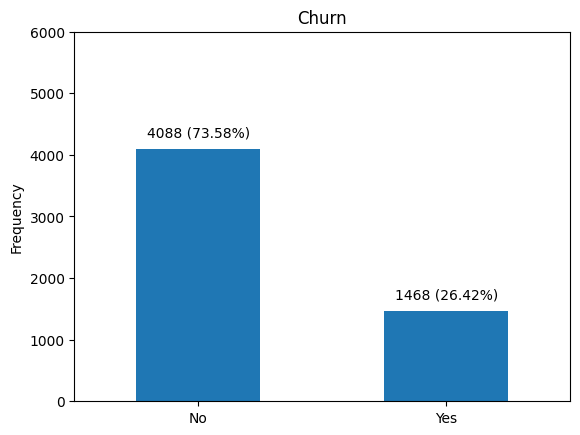

In [84]:
imbalanced_viz(y_pretrain)

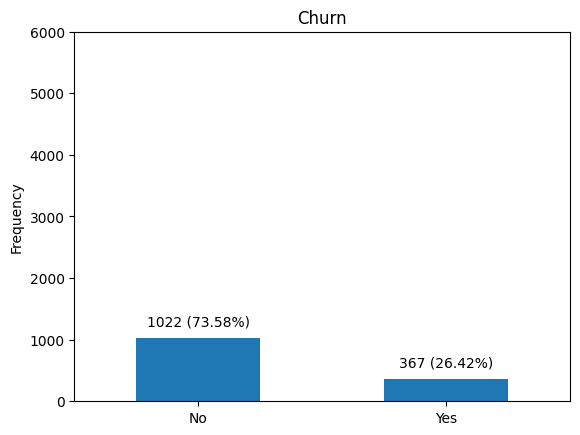

In [85]:
imbalanced_viz(y_val)

In [86]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_resample, y_resample = smote.fit_resample(X_pretrain, y_pretrain)

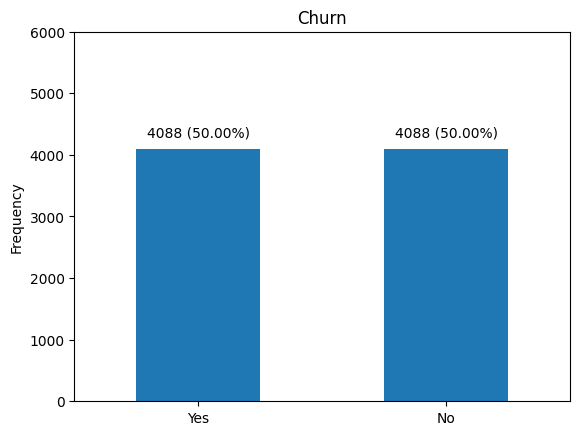

In [87]:
imbalanced_viz(y_resample)

In [88]:
# do split again
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample,
                                                    test_size=0.2,
                                                    random_state = 42)

In [89]:
# Training data shape after SMOTE
print('Shape of X_train after SMOTE : {}'.format(X_train.shape))
print('Shape of y_train after SMOTE : {}'.format(y_train.shape))
print()

# Testing data shape after SMOTE
print('Shape of X_test after SMOTE : {}'.format(X_test.shape))
print('Shape of y_test after SMOTE : {}'.format(y_test.shape))
print()

# Valication data shape before SMOTE, this is set as a unlooked up data from machine learning model
print('Shape of X_val before SMOTE : {}'.format(X_val.shape))
print('Shape of y_val before SMOTE : {}'.format(y_val.shape))

Shape of X_train after SMOTE : (6540, 21)
Shape of y_train after SMOTE : (6540,)

Shape of X_test after SMOTE : (1636, 21)
Shape of y_test after SMOTE : (1636,)

Shape of X_val before SMOTE : (1389, 21)
Shape of y_val before SMOTE : (1389,)


### Logstic Regression

In [90]:
log_model2 = LogisticRegression().fit(X_train, y_train)
y_train_pred = log_model2.predict(X_train)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred, target_names=labels))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

    No churn       0.80      0.77      0.78      3258
       Churn       0.78      0.80      0.79      3282

    accuracy                           0.79      6540
   macro avg       0.79      0.79      0.79      6540
weighted avg       0.79      0.79      0.79      6540



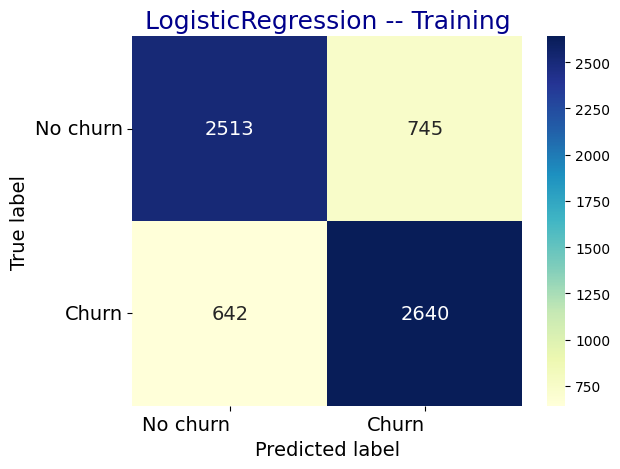

In [91]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('LogisticRegression -- Training', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [92]:
# Predict data test
y_test_pred = log_model2.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

    No churn       0.81      0.75      0.78       830
       Churn       0.76      0.82      0.79       806

    accuracy                           0.79      1636
   macro avg       0.79      0.79      0.79      1636
weighted avg       0.79      0.79      0.79      1636



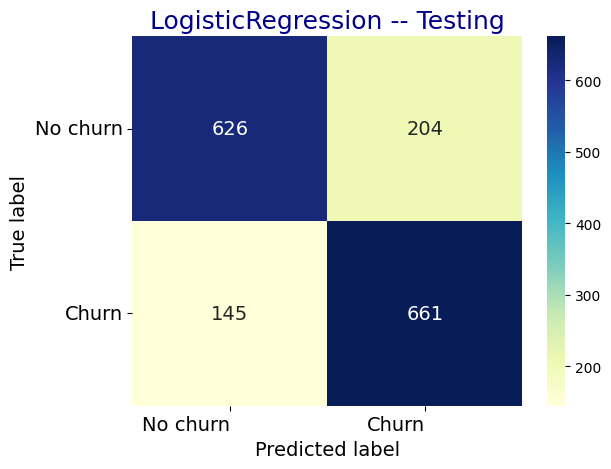

In [93]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)),('No churn','Churn'),('No churn','Churn') )
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14},fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('LogisticRegression -- Testing', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [94]:
# Predict data val
y_val_pred = log_model2.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (Logistic Regression):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (Logistic Regression):
              precision    recall  f1-score   support

    No churn       0.88      0.76      0.81      1022
       Churn       0.51      0.71      0.59       367

    accuracy                           0.74      1389
   macro avg       0.70      0.73      0.70      1389
weighted avg       0.78      0.74      0.76      1389



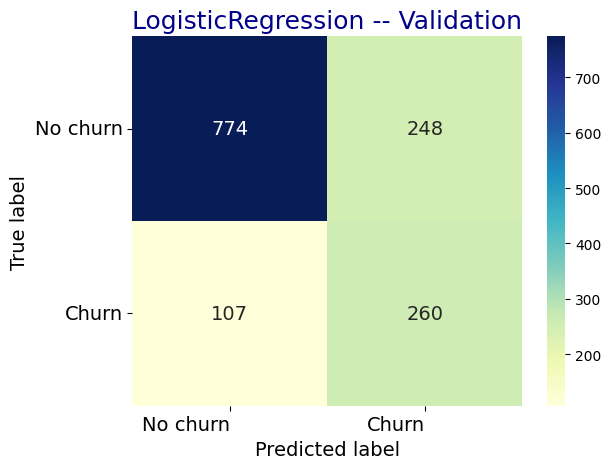

In [95]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)),('No churn','Churn'),('No churn','Churn') )
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14},fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('LogisticRegression -- Validation', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [96]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(log_model2, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]

log_model_score2 = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy', 'Validation Accuracy'])
log_model_score2.insert(0, 'Model', 'Logistic Regression')

### Decision Tree Classifier

In [97]:
tree_model2 = DecisionTreeClassifier().fit(X_train, y_train)
y_train_pred = tree_model2.predict(X_train)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Training Model (Decision Tree) :')
print(classification_report(y_train, y_train_pred, target_names=labels))

Classification Report Training Model (Decision Tree) :
              precision    recall  f1-score   support

    No churn       0.99      0.98      0.98      3258
       Churn       0.98      0.99      0.98      3282

    accuracy                           0.98      6540
   macro avg       0.98      0.98      0.98      6540
weighted avg       0.98      0.98      0.98      6540



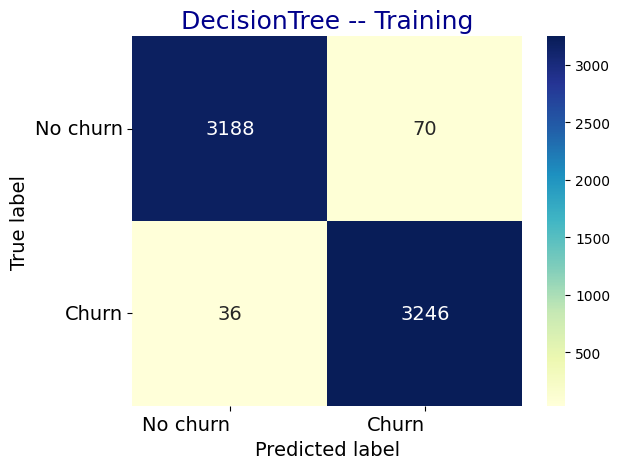

In [98]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('DecisionTree -- Training', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [99]:
y_test_pred = tree_model2.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (Decision Tree):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (Decision Tree):
              precision    recall  f1-score   support

    No churn       0.82      0.79      0.80       830
       Churn       0.79      0.82      0.80       806

    accuracy                           0.80      1636
   macro avg       0.80      0.80      0.80      1636
weighted avg       0.80      0.80      0.80      1636



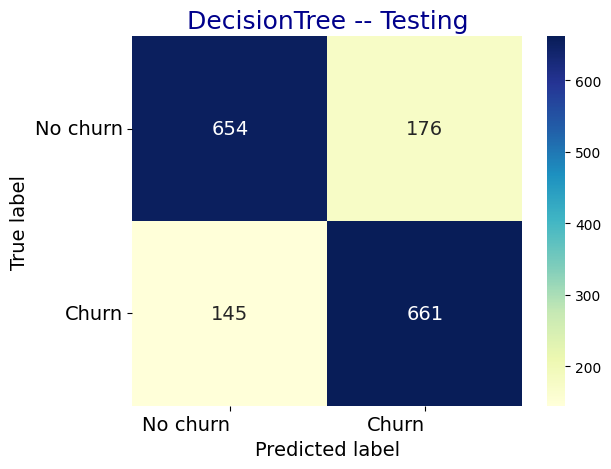

In [100]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('DecisionTree -- Testing', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [101]:
y_val_pred = tree_model2.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (Decision Tree):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (Decision Tree):
              precision    recall  f1-score   support

    No churn       0.83      0.81      0.82      1022
       Churn       0.51      0.56      0.53       367

    accuracy                           0.74      1389
   macro avg       0.67      0.68      0.67      1389
weighted avg       0.75      0.74      0.74      1389



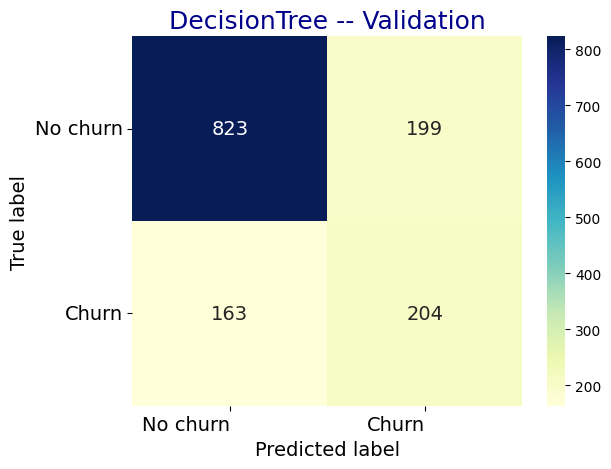

In [102]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('DecisionTree -- Validation', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [103]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(tree_model2, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]
tree_model_score2 = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy', 'Validation Accuracy'])
tree_model_score2.insert(0, 'Model', 'Decision Tree')

### Random Forest Classifier

In [104]:
rf_model2 = RandomForestClassifier().fit(X_train, y_train)
y_train_pred = rf_model2.predict(X_train)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Training Model (Random Forest Classifier) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest Classifier) :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3258
           1       0.97      0.99      0.98      3282

    accuracy                           0.98      6540
   macro avg       0.98      0.98      0.98      6540
weighted avg       0.98      0.98      0.98      6540



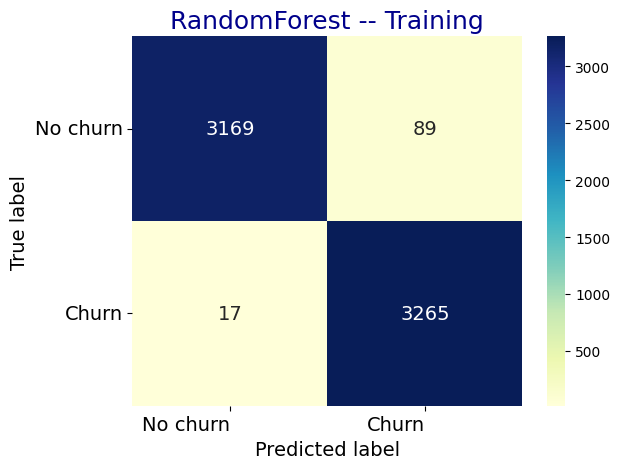

In [105]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('RandomForest -- Training', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [106]:
# Predict data test
y_test_pred = rf_model2.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

    No churn       0.87      0.82      0.84       830
       Churn       0.82      0.87      0.85       806

    accuracy                           0.84      1636
   macro avg       0.85      0.85      0.84      1636
weighted avg       0.85      0.84      0.84      1636



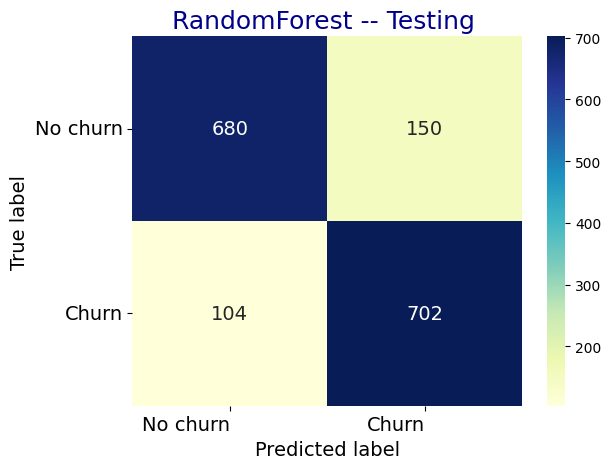

In [107]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('RandomForest -- Testing ', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [108]:
y_val_pred = rf_model2.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (Random Forest Classifier):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (Random Forest Classifier):
              precision    recall  f1-score   support

    No churn       0.85      0.85      0.85      1022
       Churn       0.58      0.58      0.58       367

    accuracy                           0.78      1389
   macro avg       0.71      0.71      0.71      1389
weighted avg       0.78      0.78      0.78      1389



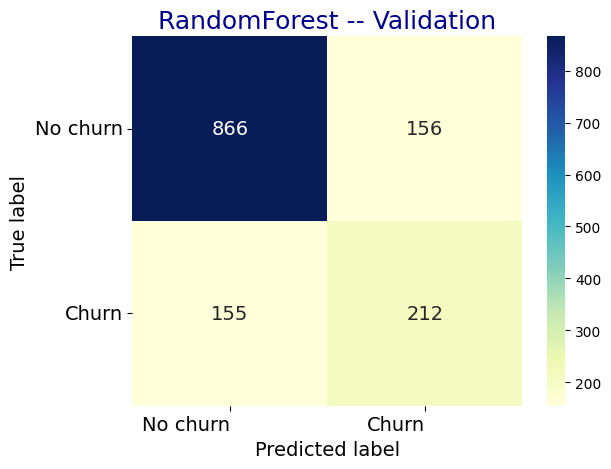

In [109]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('RandomForest -- Validation', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [110]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(rf_model2, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]

rf_model_score2 = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy','Validation Accuracy'])
rf_model_score2.insert(0, 'Model', 'Random Forest')

### Extreme Gradient Boosting (XGBoost)

In [111]:
xgb_model2 = XGBClassifier().fit(X_train, y_train)
y_train_pred = xgb_model2.predict(X_train)
labels = ['No churn', 'Churn']
# Print classification report
print('Classification Report Training Model (XGBoost):')
print(classification_report(y_train,y_train_pred, target_names=labels))

Classification Report Training Model (XGBoost):
              precision    recall  f1-score   support

    No churn       0.96      0.91      0.94      3258
       Churn       0.92      0.96      0.94      3282

    accuracy                           0.94      6540
   macro avg       0.94      0.94      0.94      6540
weighted avg       0.94      0.94      0.94      6540



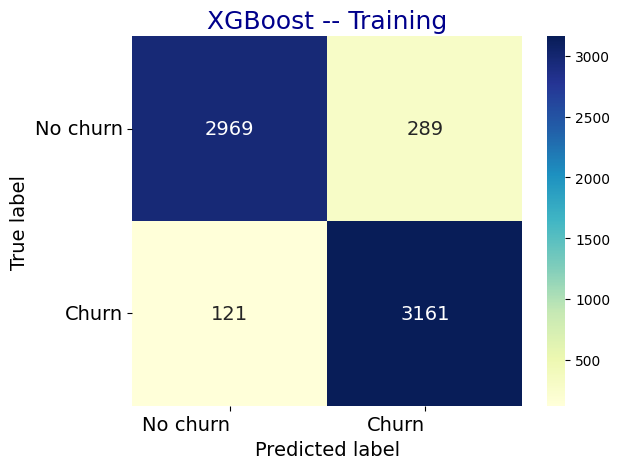

In [112]:
# Perform data training: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('XGBoost -- Training', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [113]:
# Predict data test
y_test_pred = xgb_model2.predict(X_test)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Testing Model (XGBoost):')
print(classification_report(y_test, y_test_pred, target_names=labels))

Classification Report Testing Model (XGBoost):
              precision    recall  f1-score   support

    No churn       0.88      0.82      0.85       830
       Churn       0.83      0.88      0.85       806

    accuracy                           0.85      1636
   macro avg       0.85      0.85      0.85      1636
weighted avg       0.85      0.85      0.85      1636



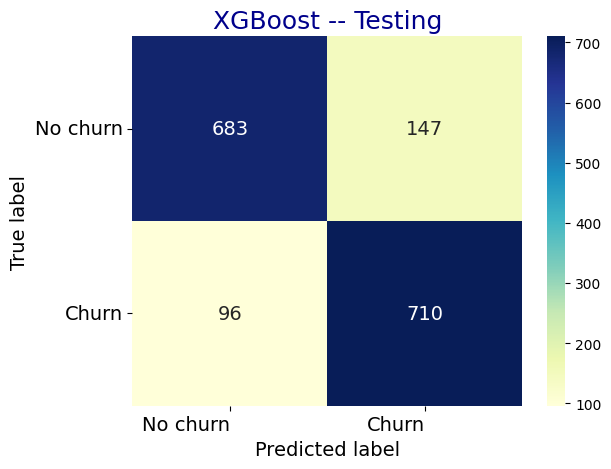

In [114]:
# Perform data test: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('XGBoost -- Testing', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [115]:
# Predict data val
y_val_pred = xgb_model2.predict(X_val)
labels = ['No churn', 'Churn']

# Print classification report
print('Classification Report Validation Model (XGBoost):')
print(classification_report(y_val, y_val_pred, target_names=labels))

Classification Report Validation Model (XGBoost):
              precision    recall  f1-score   support

    No churn       0.85      0.84      0.84      1022
       Churn       0.56      0.58      0.57       367

    accuracy                           0.77      1389
   macro avg       0.71      0.71      0.71      1389
weighted avg       0.77      0.77      0.77      1389



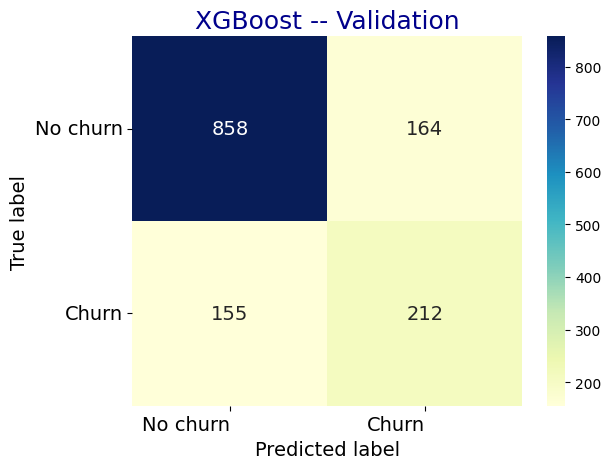

In [116]:
# Perform data val: Confusion matrix
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_val, y_val_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('XGBoost -- Validation', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [117]:
#ACCURACY TRAIN TEST VALIDATION
ndf = [Models_Evaluation_Metrics(xgb_model2, X_train, X_test, X_val, y_train, y_test, y_val, y_val_pred)]

xgb_model_score2 = pd.DataFrame(data = ndf, columns=['Training Accuracy','Test Accuracy','Validation Accuracy'])
xgb_model_score2.insert(0, 'Model', 'XGBoost')

# Finding the Best Model

In [118]:
me = pd.concat([log_model_score, tree_model_score, rf_model_score, xgb_model_score], ignore_index=True, sort=False)
print('Accuracy each models without SMOTE : \n')
me

Accuracy each models without SMOTE : 



,Model,Training Accuracy,Test Accuracy,Validation Accuracy
0,Logistic Regression,80.96,79.95,79.70
1,Decision Tree,98.31,71.67,72.50
2,Random Forest,98.31,78.15,78.98
3,XGBoost,93.70,78.60,78.19


In [119]:
me2 = pd.concat([log_model_score2, tree_model_score2, rf_model_score2, xgb_model_score2], ignore_index=True, sort=False)
print('Accuracy each models with SMOTE : \n')
me2

Accuracy each models with SMOTE : 



,Model,Training Accuracy,Test Accuracy,Validation Accuracy
0,Logistic Regression,78.79,78.67,74.44
1,Decision Tree,98.38,80.38,73.94
2,Random Forest,98.38,84.47,77.61
3,XGBoost,93.73,85.15,77.03


## Conclusion



Based on the evaluation results of model accuracy with and without SMOTE, here is the conclusion on the best algorithm to use:

- `Logistic Regression` has stable accuracy with not much difference between training, test, and validation accuracy, especially without SMOTE. However, its performance is lower compared to other models.

- `Decision Tree` shows an increase in test accuracy after using SMOTE, but has a large difference between training and test accuracy, indicating overfitting.

- `Random Forest` shows high test performance with SMOTE, but the considerable difference between training and test accuracy indicates potential overfitting.

- `XGBoost` shows high test accuracy with SMOTE and has a smaller difference between training and test accuracy compared to Random Forest, indicating a more stable model and less overfitting.

After applying SMOTE, overall, all four models showed significant performance improvements, as indicated by higher precision, recall, and F1-score values (except in logistic regression where the precision decreases). In the case of predicting churn, where we focus on churn information in the data, XGBoost has a precision of 0.56, slightly lower than Random Forest (0.58), with a higher recall of 0.58 (same with Random Forest). This is crucial because a higher recall indicates that the model can correctly identify more positive cases (Churn), meaning fewer "Churn" cases are missed by the model, thus reducing false negatives.

The `XGBoost with SMOTE` model is the best based on:

- High test accuracy (85.15%).
- Good validation accuracy (77.03%).
- Smaller difference between training and test accuracy (8.58%), indicating a more stable model and less overfitting.
-  XGBoost has a precision of 0.56, slightly lower than Random Forest (0.58), with a higher recall of 0.58.

# Save cleaned data and the best model

In [120]:
with open('df_load.pkl', 'wb') as file_1:
  joblib.dump(cleaned_df, file_1)

with open('df_load.pkl', 'rb') as file_1:
  aw = joblib.load(file_1)

In [121]:
with open('best_model_XGBoost.pkl', 'wb') as file_2:
  joblib.dump(xgb_model2, file_2)

with open('best_model_XGBoost.pkl', 'rb') as file_2:
  aw = joblib.load(file_2)